# FLYWIRE CONNECTOME ANALYSES

### Importing all packages/data

In [1]:
#Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from matplotlib_venn import venn3
from collections import Counter

In [2]:
from venn import venn

In [3]:
# Importing the neurons dataset, connections dataset, and the neurons flywire has classified as sugar/bitter/water/IR94e GRNs
# neurons = pd.read_csv('/Users/SydneyWalker/qtm 499/raw data/neurons.csv.gz')

connections = pd.read_csv('/Users/SydneyWalker/qtm 499/raw data/connections.csv.gz')
sugar_GRNs = pd.read_csv('/Users/SydneyWalker/qtm 499/raw data/sugar_GRNs.csv').query("side == 'left'")
sugar_GRNs.drop(index = 21, inplace=True) # neuron 720575940623172843 -- not corroborated by Shiu
bitter_GRNs = pd.read_csv('/Users/SydneyWalker/qtm 499/raw data/bitter_GRNs.csv').query("side == 'left'")
# added 720575940617094208
water_GRNs = pd.read_csv('/Users/SydneyWalker/qtm 499/raw data/water_GRNs.csv').query("side == 'left'") 
lowsalt_GRNs = pd.read_csv('/Users/SydneyWalker/qtm 499/raw data/lowsalt_GRNs.csv').query("side == 'left'")
lowsalt_GRNs.drop(index = [1,8], inplace=True) # neurons 720575940615274425, 720575940626241636 -- not corroborated by Shiu

In [4]:
def second_order(taste_GRNs, connections_dataset,name, taste_2Ns):
    for entry in taste_GRNs['root_id']:
        merge = pd.merge(taste_GRNs, connections, left_on = 'root_id', right_on = 'pre_root_id', how = 'inner')
        merge_grouped = merge.groupby("post_root_id")["syn_count"].sum().reset_index()
        merge_grouped.columns = ['root_id', name + '_syn_count']
        taste_2Ns = pd.merge(taste_2Ns, merge_grouped, on = 'root_id', how = 'inner')
        return taste_2Ns        

In [5]:
# importing the neurons {downstream} of sugar/bitter/water/IR94e
# THRESHOLD = ATLEAST 10 CONNECTIONS FROM GRN

sugar2N_data = pd.read_csv('/Users/SydneyWalker/qtm 499/raw data/sugar_2Ns.csv')[['root_id','label','input_synapses','output_synapses']]
bitter2N_data = pd.read_csv('/Users/SydneyWalker/qtm 499/raw data/bitter_2Ns.csv')[['root_id','label','input_synapses','output_synapses']]
water2N_data = pd.read_csv('/Users/SydneyWalker/qtm 499/raw data/water_2Ns.csv')[['root_id','label','input_synapses','output_synapses']]
lowsalt2N_data = pd.read_csv('/Users/SydneyWalker/qtm 499/raw data/lowsalt_2Ns.csv')[['root_id','label','input_synapses','output_synapses']]

In [6]:
sugar_2Ns = second_order(sugar_GRNs, connections, 'sugar', sugar2N_data)
bitter_2Ns = second_order(bitter_GRNs, connections, 'bitter', bitter2N_data)
water_2Ns = second_order(water_GRNs, connections, 'water', water2N_data)
lowsalt_2Ns = second_order(lowsalt_GRNs, connections, 'lowsalt', lowsalt2N_data)

In [7]:
# reorganizing the connections dataset to be ordered by the identifying upstream 
# neuron and labeling each by the number of synapses between them 
# THRESHOLD FOR LATER???????

results = connections.groupby(['pre_root_id', 'post_root_id','neuropil'])['syn_count'].sum().reset_index()

In [8]:
#gives us the number of upstream cells of all second order cells based on connections dataset

cells_upstream = connections.groupby('post_root_id')['pre_root_id'].nunique().reset_index()
cells_upstream.columns = ['second_order_cell_ID', '#_upstream_cells']

## FIRST ORDERS

### Confirming that first order cells within each modality are distict from other modalities

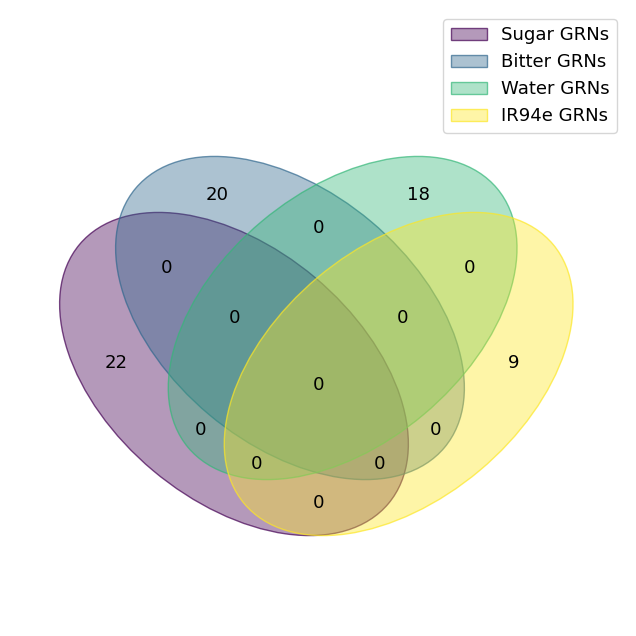

In [9]:
sugar_column = 'Sugar GRNs'
sugar_list = {'{}'.format(value) for value in sugar_GRNs['root_id'].unique()}
sugar_dict = {sugar_column: sugar_list}

bitter_column = 'Bitter GRNs'
bitter_list = {'{}'.format(value) for value in bitter_GRNs['root_id'].unique()}
bitter_dict = {bitter_column: bitter_list}

water_column = 'Water GRNs'
water_list = {'{}'.format(value) for value in water_GRNs['root_id'].unique()}
water_dict = {water_column: water_list}

lowsalt_column = 'IR94e GRNs'
lowsalt_list = {'{}'.format(value) for value in lowsalt_GRNs['root_id'].unique()}
lowsalt_dict = {lowsalt_column: lowsalt_list}

crossover = {**sugar_dict, **bitter_dict, **water_dict, **lowsalt_dict}
venn(crossover)
plt.show()

## SECOND ORDERS

### Looking at the proportion of input second-orders receive from their own modality (# synapses and # cells)
This code will provide information abut of second order order GRNs and their
- ratio of input taste/non-taste synapses
- ratio of input taste/non-taste cells
- number of output synapses  and their input/output synapse and cell ratios

In [10]:
# extracting sugar neurons from the results dataset, pre_root_id = sugar GRNs, post_root_id = first order
# sugar neurons
sugar_merge = pd.merge(results, sugar_GRNs['root_id'], left_on = 'pre_root_id', right_on = 'root_id', how = 'inner')
sugar_merge = sugar_merge.drop(columns='root_id')

sugar_merge2 = pd.merge(sugar_merge, sugar_2Ns, left_on = 'post_root_id', right_on = 'root_id', how = 'inner')
sugar_connections = sugar_merge2.groupby('post_root_id')['syn_count'].sum().reset_index()
sugar_labels = pd.merge(sugar_connections, sugar_2Ns,left_on = 'post_root_id', right_on = 'root_id', how = 'inner')
sugar_labels = sugar_labels.drop(columns = 'root_id')

sugar_labels.rename(columns={'input_synapses': 'total_#_input_synapses','syn_count':'#_input_sugar_GRN_synapses','post_root_id':'second_order_cell_ID'}, inplace=True)
sugar_labels['%_input_from_sugar_GRNs'] = sugar_labels['#_input_sugar_GRN_synapses'] / sugar_labels['total_#_input_synapses'] * 100
sugar_labels = sugar_labels.sort_values(by = '%_input_from_sugar_GRNs', ascending = False)

#ADDING THIS:
sugar_labels = sugar_labels[sugar_labels['#_input_sugar_GRN_synapses'] >= 10]


# RETURN TO NORMAL
sugar_upstream = sugar_merge2.groupby('post_root_id')['pre_root_id'].nunique().reset_index()
sugar_upstream.columns = ['second_order_cell_ID', '#_upstream_sugar_cells']

sugar_labels2 = pd.merge(sugar_labels, sugar_upstream, on = 'second_order_cell_ID')
sugar_labels2 = pd.merge(sugar_labels2, cells_upstream, on = 'second_order_cell_ID', how = 'inner')

#SUGAR_LABELS2 

In [11]:
water_merge = pd.merge(results, water_GRNs['root_id'], left_on = 'pre_root_id', right_on = 'root_id', how = 'inner')
water_merge = water_merge.drop(columns='root_id')

water_merge2 = pd.merge(water_merge, water_2Ns, left_on = 'post_root_id', right_on = 'root_id', how = 'inner')
water_connections = water_merge2.groupby('post_root_id')['syn_count'].sum().reset_index()

water_labels = pd.merge(water_connections, water_2Ns,left_on = 'post_root_id', right_on = 'root_id', how = 'inner')
water_labels = water_labels.drop(columns = 'root_id')

water_labels.rename(columns={'input_synapses': 'total_#_input_synapses','syn_count':'#_input_water_GRN_synapses','post_root_id':'second_order_cell_ID'}, inplace=True)
water_labels['%_input_from_water_GRNs'] = water_labels['#_input_water_GRN_synapses'] / water_labels['total_#_input_synapses'] * 100
water_labels = water_labels.sort_values(by = '%_input_from_water_GRNs', ascending = False)


#ADDING THIS:
# water_labels = water_labels[water_labels['#_input_water_GRN_synapses'] >= 10]


# RETURN TO NORMAL
water_upstream = water_merge2.groupby('post_root_id')['pre_root_id'].nunique().reset_index()
water_upstream.columns = ['second_order_cell_ID', '#_upstream_water_cells']

water_labels2 = pd.merge(water_labels, water_upstream, on = 'second_order_cell_ID')
water_labels2 = pd.merge(water_labels2, cells_upstream, on = 'second_order_cell_ID', how = 'inner')

#WATER_LABELS2

In [12]:
bitter_merge = pd.merge(results, bitter_GRNs['root_id'], left_on = 'pre_root_id', right_on = 'root_id', how = 'inner')
bitter_merge = bitter_merge.drop(columns='root_id')

bitter_merge2 = pd.merge(bitter_merge, bitter_2Ns, left_on = 'post_root_id', right_on = 'root_id', how = 'inner')
bitter_connections = bitter_merge2.groupby('post_root_id')['syn_count'].sum().reset_index()

bitter_labels = pd.merge(bitter_connections, bitter_2Ns,left_on = 'post_root_id', right_on = 'root_id', how = 'inner')
bitter_labels = bitter_labels.drop(columns = 'root_id')

bitter_labels.rename(columns={'input_synapses': 'total_#_input_synapses','syn_count':'#_input_bitter_GRN_synapses','post_root_id':'second_order_cell_ID'}, inplace=True)
bitter_labels['%_input_from_bitter_GRNs'] = bitter_labels['#_input_bitter_GRN_synapses'] / bitter_labels['total_#_input_synapses'] * 100
bitter_labels = bitter_labels.sort_values(by = '%_input_from_bitter_GRNs', ascending = False)


#ADDING THIS:
# bitter_labels = bitter_labels[bitter_labels['# input bitter GRN synapses'] >= 10]


# RETURN TO NORMAL
bitter_upstream = bitter_merge2.groupby('post_root_id')['pre_root_id'].nunique().reset_index()
bitter_upstream.columns = ['second_order_cell_ID', '#_upstream_bitter_cells']

bitter_labels2 = pd.merge(bitter_labels, bitter_upstream, on = 'second_order_cell_ID')
bitter_labels2 = pd.merge(bitter_labels2, cells_upstream, on = 'second_order_cell_ID', how = 'inner')

#BITTER_LABELS2

In [13]:
result = connections.groupby(['pre_root_id', 'post_root_id','neuropil'])['syn_count'].sum().reset_index()

lowsalt_merge = pd.merge(result, lowsalt_GRNs['root_id'], left_on = 'pre_root_id', right_on = 'root_id', how = 'inner')
lowsalt_merge = lowsalt_merge.drop(columns='root_id')

lowsalt_merge2 = pd.merge(lowsalt_merge, lowsalt_2Ns, left_on = 'post_root_id', right_on = 'root_id', how = 'inner')
lowsalt_connections = lowsalt_merge2.groupby(['post_root_id'])['syn_count'].sum().reset_index()

lowsalt_labels = pd.merge(lowsalt_connections, lowsalt_2Ns,left_on = 'post_root_id', right_on = 'root_id', how = 'inner')
lowsalt_labels = lowsalt_labels.drop(columns = 'root_id')

lowsalt_labels.rename(columns={'input_synapses': 'total_num_input_synapses','syn_count':'num_input_lowsalt_synapses','post_root_id':'second_order_cell_ID'}, inplace=True)
lowsalt_labels['percent_input_from_lowsalt_GRNs'] = lowsalt_labels['num_input_lowsalt_synapses'] / lowsalt_labels['total_num_input_synapses'] * 100
lowsalt_labels = lowsalt_labels.sort_values(by = 'percent_input_from_lowsalt_GRNs', ascending = False)


#ADDING THIS:
# lowsalt_labels = lowsalt_labels[lowsalt_labels['num_input_lowsalt_synapses'] >= 10]


# RETURN TO NORMAL
lowsalt_upstream = lowsalt_merge2.groupby('post_root_id')['pre_root_id'].nunique().reset_index()
lowsalt_upstream.columns = ['second_order_cell_ID', 'num_upstream_lowsalt_cells']

lowsalt_labels2 = pd.merge(lowsalt_labels, lowsalt_upstream, on = 'second_order_cell_ID')
lowsalt_labels2 = pd.merge(lowsalt_labels2, cells_upstream, on = 'second_order_cell_ID', how = 'inner')

#LOWSALT_LABELS2

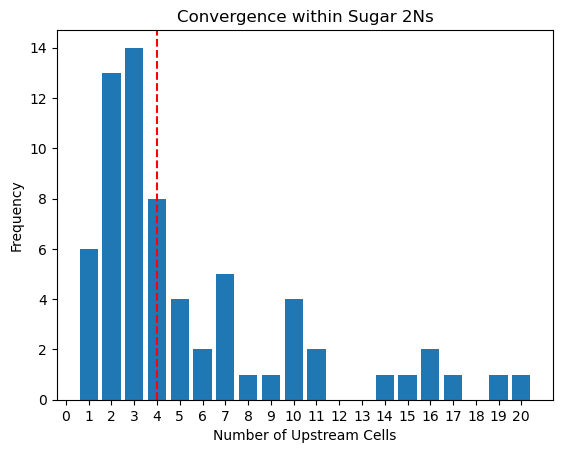

In [14]:
#Visualizing convergence within Sugar 2Ns
#Outputs a bar chart with the number of upstream cells for each 2N

data = Counter(sugar_labels2['#_upstream_sugar_cells'])
labels = list(data.keys())
frequencies = list(data.values())
plt.bar(labels, frequencies)
plt.axvline(x=np.median(sugar_labels2['#_upstream_sugar_cells']), color='r', linestyle='--', label='Median')
plt.xticks(np.arange(0, max(sugar_labels2['#_upstream_sugar_cells']) + 1, step=1))
plt.xlabel('Number of Upstream Cells')
plt.ylabel('Frequency')
plt.title('Convergence within Sugar 2Ns')
plt.show()


# COME BACK  on y-axis also look at number synapses/input from upstream cells.. is it 5 from each upstream cell whether there's 2 or 20 upstream?


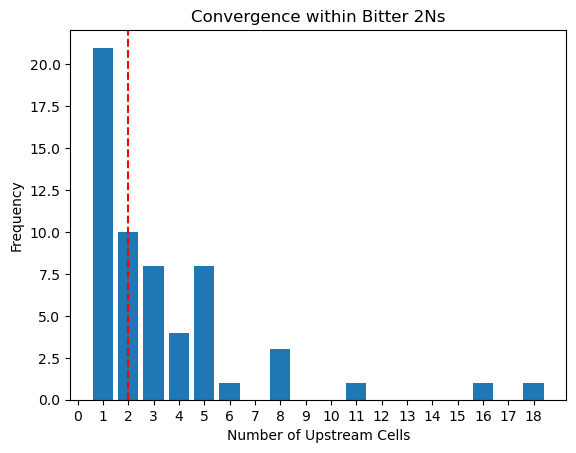

In [15]:
#Visualizing convergence within Bitter 2Ns
#Outputs a bar chart with the number of upstream cells for each 2N

data = Counter(bitter_labels2['#_upstream_bitter_cells'])
labels = list(data.keys())
frequencies = list(data.values())
plt.bar(labels, frequencies)
plt.axvline(x=np.median(bitter_labels2['#_upstream_bitter_cells']), color='r', linestyle='--', label='Median')
plt.xticks(np.arange(0, max(bitter_labels2['#_upstream_bitter_cells']) + 1, step=1))
plt.xlabel('Number of Upstream Cells')
plt.ylabel('Frequency')
plt.title('Convergence within Bitter 2Ns')
plt.show()


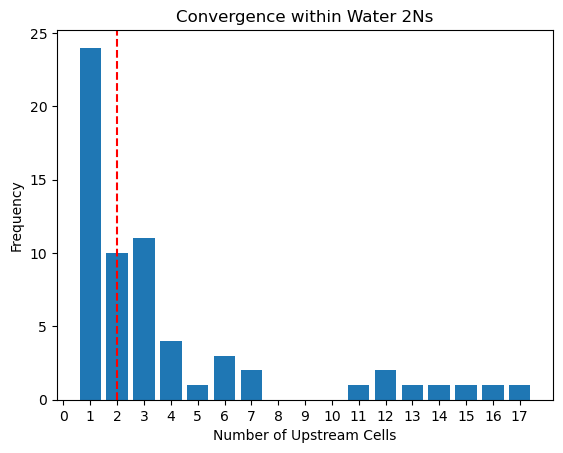

In [16]:
#Visualizing convergence within Bitter 2Ns
#Outputs a bar chart with the number of upstream cells for each 2N

data = Counter(water_labels2['#_upstream_water_cells'])
labels = list(data.keys())
frequencies = list(data.values())
plt.bar(labels, frequencies)
plt.axvline(x=np.median(water_labels2['#_upstream_water_cells']), color='r', linestyle='--', label='Median')
plt.xticks(np.arange(0, max(water_labels2['#_upstream_water_cells']) + 1, step=1))
plt.xlabel('Number of Upstream Cells')
plt.ylabel('Frequency')
plt.title('Convergence within Water 2Ns')
plt.show()


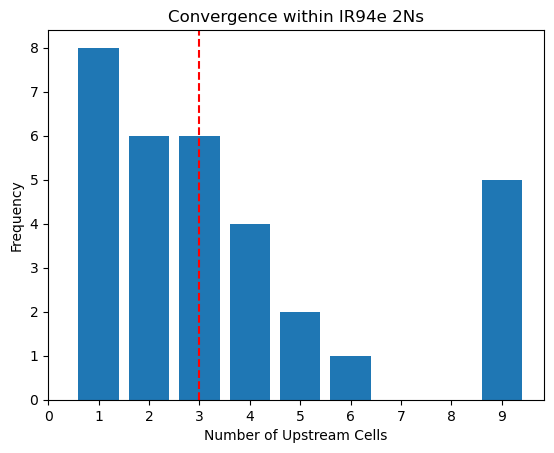

In [17]:
#Visualizing convergence within IR94e 2Ns
#Outputs a bar chart with the number of upstream cells for each 2N

data = Counter(lowsalt_labels2['num_upstream_lowsalt_cells'])
labels = list(data.keys())
frequencies = list(data.values())
plt.bar(labels, frequencies)
plt.axvline(x=np.median(lowsalt_labels2['num_upstream_lowsalt_cells']), color='r', linestyle='--', label='Median')
plt.xticks(np.arange(0, max(lowsalt_labels2['num_upstream_lowsalt_cells']) + 1, step=1))
plt.xlabel('Number of Upstream Cells')
plt.ylabel('Frequency')
plt.title('Convergence within IR94e 2Ns')
plt.show()

In [18]:
# This funtion will output second order cells and their input/output synapses

def function(result, taste_GRNs, neuron_downstream, name):
    merge = pd.merge(result, taste_GRNs['root_id'], left_on = 'pre_root_id', right_on = 'root_id', how = 'inner')
    merge = merge.drop(columns='root_id')
    merge2 = pd.merge(merge, neuron_downstream, left_on = 'post_root_id', right_on = 'root_id', how = 'inner')
    connections = merge2.groupby('post_root_id')['syn_count'].sum().reset_index()
    labels = pd.merge(connections, neuron_downstream,left_on = 'post_root_id', right_on = 'root_id', how = 'inner')
    labels = labels.drop(columns = 'root_id')
    labels.rename(columns={'input_synapses': 'total_#_input_synapses','syn_count':'#_input_' + name + '_synapses','post_root_id':'second_order_cell_ID'}, inplace=True)
    labels['% input from ' + name + ' GRNs'] = labels['#_input_' + name + '_synapses'] / labels['total_#_input_synapses'] * 100
    labels = labels.sort_values(by = '% input from ' + name + ' GRNs', ascending = False)
    return labels

In [19]:
# Second order cells and their input/output synapses

sugar_data = function(results, sugar_GRNs, sugar_2Ns, "sugar")
bitter_data = function(results, bitter_GRNs, bitter_2Ns, "bitter")
water_data = function(results, water_GRNs, water_2Ns, "water")
lowsalt_data = function(results, lowsalt_GRNs, lowsalt_2Ns, "lowsalt")

#ADDING THIS:
# sugar_data = sugar_data[sugar_data['#_input_sugar_synapses'] >= 10]
# bitter_data = bitter_data[bitter_data['#_input_bitter_synapses'] >= 10]
# water_data = water_data[water_data['#_input_water_synapses'] >= 10]
# lowsalt_data = lowsalt_data[lowsalt_data['#_input_lowsalt_synapses'] >= 10]

### Examining the total amount of synaptic input second order cells receive
- This is a cumulative distribution across all taste modalities

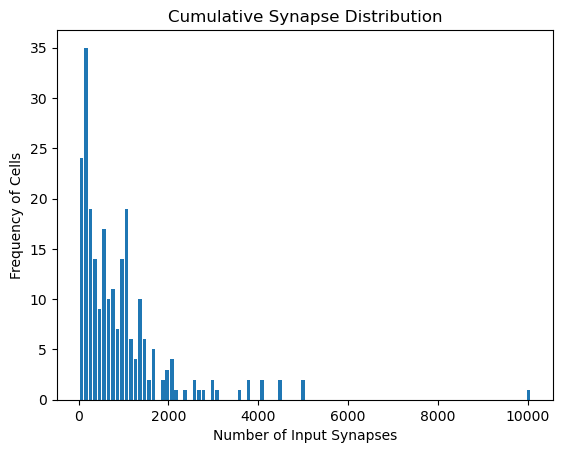

In [20]:
# Synapse distribution for all modalities

input = []

for entry in sugar_data['total_#_input_synapses']:
    input.append(entry)
for entry in water_data['total_#_input_synapses']:
    input.append(entry)
for entry in bitter_data['total_#_input_synapses']:
    input.append(entry)
for entry in lowsalt_data['total_#_input_synapses']:
    input.append(entry)


data = input

num_bins = 100
bins = np.linspace(min(data), max(data), num_bins + 1)
frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
plt.bar(bin_labels, frequencies, width=(max(data) - min(data)) / num_bins * 0.8, align='center')
plt.xlabel('Number of Input Synapses')
plt.ylabel('Frequency of Cells')
plt.title('Cumulative Synapse Distribution')
plt.show()

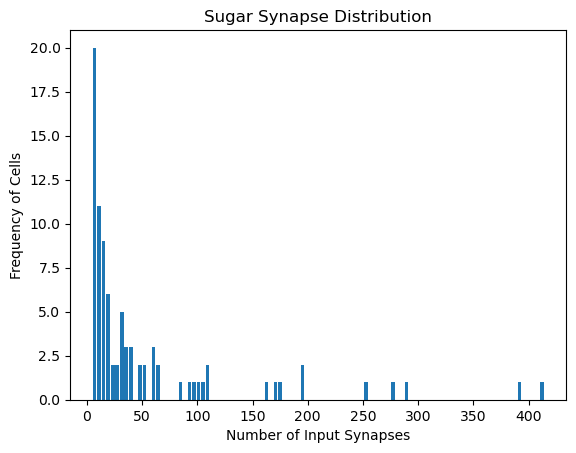

In [21]:
# Synapse distribution for sugar

data = sugar_data['#_input_sugar_synapses']

num_bins = 100
bins = np.linspace(min(data), max(data), num_bins + 1)
frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
plt.bar(bin_labels, frequencies, width=(max(data) - min(data)) / num_bins * 0.8, align='center')
#plt.axvline(x=np.median(sugar_labels2['#_input_sugar_synapses']), color='r', linestyle='--', label='Median')
plt.xlabel('Number of Input Synapses')
plt.ylabel('Frequency of Cells')
plt.title('Sugar Synapse Distribution')
plt.show()

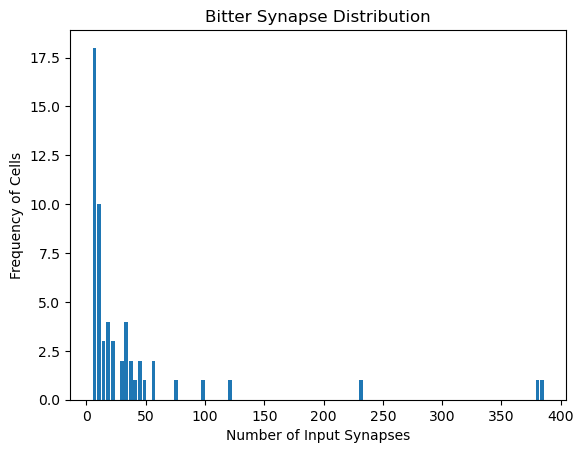

In [22]:
# Synapse distribution for bitter

data = bitter_data['#_input_bitter_synapses'] 

num_bins = 100
bins = np.linspace(min(data), max(data), num_bins + 1)
frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
plt.bar(bin_labels, frequencies, width=(max(data) - min(data)) / num_bins * 0.8, align='center')
plt.xlabel('Number of Input Synapses')
plt.ylabel('Frequency of Cells')
plt.title('Bitter Synapse Distribution')
plt.show()

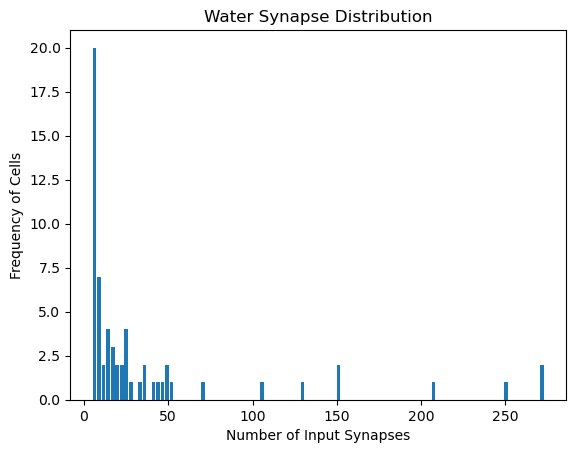

In [23]:
# Synapse distribution for water

data = water_data['#_input_water_synapses'] 

num_bins = 100
bins = np.linspace(min(data), max(data), num_bins + 1)
frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
plt.bar(bin_labels, frequencies, width=(max(data) - min(data)) / num_bins * 0.8, align='center')
plt.xlabel('Number of Input Synapses')
plt.ylabel('Frequency of Cells')
plt.title('Water Synapse Distribution')
plt.show()

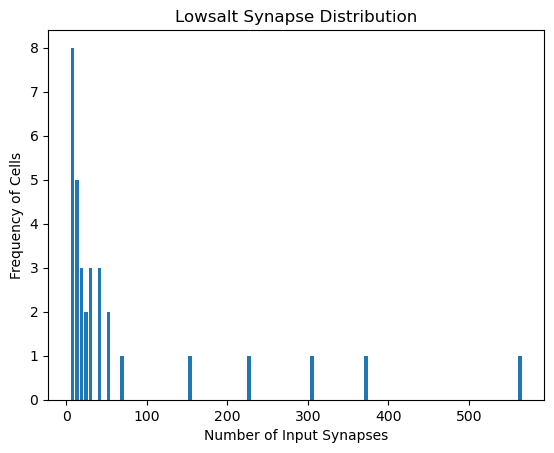

In [24]:
# Synapse distribution for lowsalt

data = lowsalt_data['#_input_lowsalt_synapses']

num_bins = 100
bins = np.linspace(min(data), max(data), num_bins + 1)
frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
plt.bar(bin_labels, frequencies, width=(max(data) - min(data)) / num_bins * 0.8, align='center')
plt.xlabel('Number of Input Synapses')
plt.ylabel('Frequency of Cells')
plt.title('Lowsalt Synapse Distribution')
plt.show()

In [25]:
# Classifying second order sugar cells based on their ratio of input/output
# DELETE ?

# sugar_celltype = pd.read_csv('/Users/SydneyWalker/Downloads/sugar_downstream_test.csv')
# sugar2N_broadcasters = sugar_celltype[sugar_celltype['output_synapses']/sugar_celltype['input_synapses'] >= 3 ][['root_id','input_synapses','output_synapses']]
# sugar2N_broadcasters['type'] = 'broadcaster'
# sugar2N_integrators = sugar_celltype[sugar_celltype['input_synapses']/sugar_celltype['output_synapses'] >= 3 ][['root_id','input_synapses','output_synapses']]
# sugar2N_integrators['type'] = 'integrator'

# sugar2N = pd.merge(sugar2N_broadcasters, sugar2N_integrators, how = 'outer') 
# sugar2N_counts = sugar2N['type'].value_counts()
# colors = ['magenta', 'lime']
# sugar2N_counts.plot(kind = 'bar', color =colors)
# plt.xlabel('Type')
# plt.ylabel('Frequency')
# plt.title('Sugar 2N Classifications')
# plt.show()

In [26]:
# Classifying second order bitter cells based on their ratio of input/output
# DELETE ?

# bitter_celltype = pd.read_csv('/Users/SydneyWalker/Downloads/bitter_downstream_test.csv')
# bitter2N_broadcasters = bitter_celltype[bitter_celltype['output_synapses']/bitter_celltype['input_synapses'] >= 3 ][['root_id','input_synapses','output_synapses']]
# bitter2N_broadcasters['type'] = 'broadcaster'
# bitter2N_integrators = bitter_celltype[bitter_celltype['input_synapses']/bitter_celltype['output_synapses'] >= 3 ][['root_id','input_synapses','output_synapses']]
# bitter2N_integrators['type'] = 'integrator'
# bitter2N = pd.merge(bitter2N_broadcasters, bitter2N_integrators, how = 'outer') 
# bitter2N_counts = bitter2N['type'].value_counts()
# colors = ['magenta', 'lime']
# bitter2N_counts.plot(kind = 'bar', color = colors)
# plt.xlabel('Type')
# plt.ylabel('Frequency')
# plt.title('Bitter 2N Classifications')
# plt.show()

In [27]:
# Classifying second order water cells based on their ratio of input/output
# DELETE ?

# water_celltype = pd.read_csv('/Users/SydneyWalker/Downloads/water_downstream_test.csv')
# water2N_broadcasters = water_celltype[water_celltype['output_synapses']/water_celltype['input_synapses'] >= 3 ][['root_id','input_synapses','output_synapses']]
# water2N_broadcasters['type'] = 'broadcaster'
# water2N_integrators = water_celltype[water_celltype['input_synapses']/water_celltype['output_synapses'] >= 3 ][['root_id','input_synapses','output_synapses']]
# water2N_integrators['type'] = 'integrator'
# water2N = pd.merge(water2N_broadcasters, water2N_integrators, how = 'outer') 
# water2N_counts = water2N['type'].value_counts()
# colors = ['magenta', 'lime']
# water2N_counts.plot(kind = 'bar', color = colors)
# plt.xlabel('Type')
# plt.ylabel('Frequency')
# plt.title('Water 2N Classifications')
# plt.show()

In [28]:
# Classifying second order IR94e cells based on their ratio of input/output
# DELETE ?

# lowsalt_celltype = pd.read_csv('/Users/SydneyWalker/Downloads/lowsalt_downstream_test.csv')
# lowsalt2N_broadcasters = lowsalt_celltype[lowsalt_celltype['output_synapses']/lowsalt_celltype['input_synapses'] >= 3 ][['root_id','input_synapses','output_synapses']]
# lowsalt2N_broadcasters['type'] = 'broadcaster'
# lowsalt2N_integrators = lowsalt_celltype[lowsalt_celltype['input_synapses']/lowsalt_celltype['output_synapses'] >= 3 ][['root_id','input_synapses','output_synapses']]
# lowsalt2N_integrators['type'] = 'integrator'
# lowsalt2N = pd.merge(lowsalt2N_broadcasters, lowsalt2N_integrators, how = 'outer') 
# lowsalt2N_counts = lowsalt2N['type'].value_counts()
# colors = ['magenta', 'lime']
# lowsalt2N_counts.plot(kind = 'bar', color = colors)
# plt.xlabel('Type')
# plt.ylabel('Frequency')
# plt.title('Lowsalt 2N Classifications')
# plt.show()

### Looking at the cross-over between modalities within the second-order cells
This code will provide information about how many cells are downstream from multiple distinct taste modalities 

In [29]:
#This function identifies neurons that are classified as both sugar and water second order cells

def overlap(neuron_data1, neuron_data2, taste1, taste2):
    merge = pd.merge(neuron_data1[['second_order_cell_ID', 'label','#_input_' + taste1 + '_synapses', '% input from ' + taste1 + ' GRNs']], neuron_data2[['second_order_cell_ID', '#_input_' + taste2 + '_synapses','% input from ' + taste2 + ' GRNs','total_#_input_synapses']], on= 'second_order_cell_ID', how = 'inner')
    return merge

In [30]:
# The neurons that receive input from multiple taste modalities 

sugarwater = overlap(sugar_data, water_data, "sugar", "water")
sugarbitter = overlap(sugar_data, bitter_data, "sugar", "bitter")
waterbitter = overlap(water_data, bitter_data, "water", "bitter")
sugarlowsalt = overlap(sugar_data, lowsalt_data, "sugar", "lowsalt")
waterlowsalt =  overlap(water_data, lowsalt_data, "water", "lowsalt")
lowsaltbitter = overlap(lowsalt_data, bitter_data, "lowsalt", "bitter")

In [31]:
for entry in sugarwater['second_order_cell_ID']:
    #if entry in sugarwater['second_order_cell_ID']:
        print (entry)


# for entry in neuron_data['second_order_cell_ID']:
#         if entry in sugar_GRNs['root_id']:

720575940622695448
720575940629888530
720575940616885538
720575940620874757
720575940627383685
720575940626191306
720575940632648612
720575940616103218
720575940612670570
720575940655014049
720575940619588568
720575940618696989
720575940614763666
720575940619973712
720575940628853239
720575940611015122
720575940641366517
720575940628114684
720575940638103349
720575940617593233
720575940633277209
720575940612648106
720575940639198653
720575940625102692
720575940632047890
720575940647033396
720575940632877869
720575940637763135
720575940639274147
720575940630689644
720575940621329328


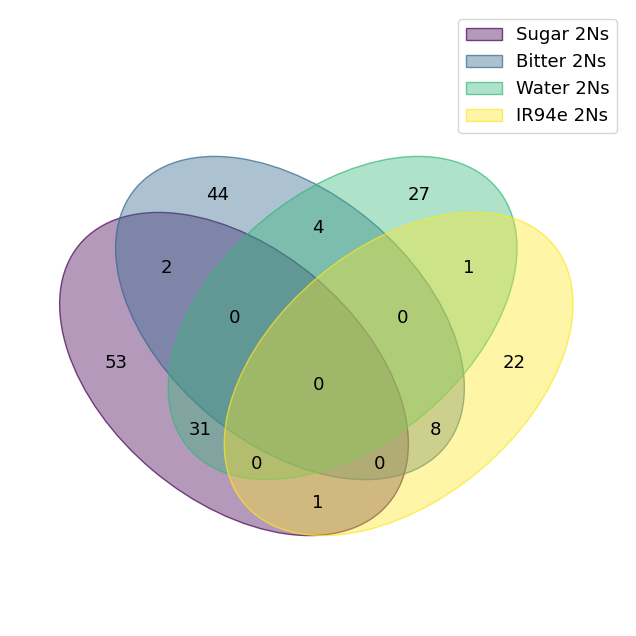

In [32]:
#Creating a venn diagram to display the crossover between the four taste modalities 

sugar_column = 'Sugar 2Ns'
sugar_list = {'{}'.format(value) for value in sugar_data['second_order_cell_ID'].unique()}
sugar_dict = {sugar_column: sugar_list}

bitter_column = 'Bitter 2Ns'
bitter_list = {'{}'.format(value) for value in bitter_data['second_order_cell_ID'].unique()}
bitter_dict = {bitter_column: bitter_list}

water_column = 'Water 2Ns'
water_list = {'{}'.format(value) for value in water_data['second_order_cell_ID'].unique()}
water_dict = {water_column: water_list}

lowsalt_column = 'IR94e 2Ns'
lowsalt_list = {'{}'.format(value) for value in lowsalt_data['second_order_cell_ID'].unique()}
lowsalt_dict = {lowsalt_column: lowsalt_list}

crossover = {**sugar_dict, **bitter_dict, **water_dict, **lowsalt_dict}
venn(crossover)
plt.show()

In [33]:
# Creating a function that tracks the second order cells which recive input from multiple taste modalities 
# calculates % input from each distinct modality

def overlap(neuron_data1, neuron_data2, taste1, taste2):
    merge = pd.merge(neuron_data1[['second_order_cell_ID', 'label','#_input_' + taste1 + '_synapses', '% input from ' + taste1 + ' GRNs']], neuron_data2[['second_order_cell_ID', '#_input_' + taste2 + '_synapses','% input from ' + taste2 + ' GRNs','total_#_input_synapses']], on= 'second_order_cell_ID', how = 'inner')
    return merge

### Looking at the location of projections for second order cells in all modalities 

In [34]:
# This function classifies neurons as local or non-local based on whether they have one or more 
# connections outside of the SEZ
# THRESHOLD = ATLEAST 10 CONNECTIONS FROM GRN

def classify2N(taste_third_order):
    classification = pd.DataFrame(columns = ['second_order_cell_ID', 'projection','#_of_external_projections'])
    unique_values = taste_third_order['second_order_cell_ID'].unique()
    for entry in unique_values:
        if all(taste_third_order[taste_third_order['second_order_cell_ID'] == entry]['location_of_connection'] == 'local'):
        #if (taste_third_order[taste_third_order['second_order_cell_ID'] == entry]['location_of_connection'] == 'local').sum()/len(taste_third_order[taste_third_order['second_order_cell_ID'] == entry]) >= 0.1:
            x = pd.DataFrame({'second_order_cell_ID': [entry], 'projection':'local','#_of_external_projections':(taste_third_order[taste_third_order['second_order_cell_ID'] == entry]['location_of_connection'] == 'outside_SEZ').sum()})
            classification = pd.concat([classification,x])
        else:
            x = pd.DataFrame({'second_order_cell_ID': [entry], 'projection':'outside_SEZ','#_of_external_projections':(taste_third_order[taste_third_order['second_order_cell_ID'] == entry]['location_of_connection'] == 'outside_SEZ').sum()})
            classification = pd.concat([classification,x])
    return classification

#### Third order...

In [35]:
# This function will output second to third order connections, synapse count and their location
# Minimum number of synapses = 5

def third_order(neuron_data, connections_dataset,taste_GRNs):
    for entry in neuron_data['second_order_cell_ID']:
        if entry in sugar_GRNs['root_id']:
            pass
        else:
            merge = pd.merge(neuron_data[['second_order_cell_ID','label']], connections, left_on='second_order_cell_ID', right_on='pre_root_id', how = 'inner').query("syn_count >=10")
        merge = merge.drop(columns = 'pre_root_id')
        merge = merge.rename(columns={'post_root_id':'third_order_cell_ID','label':'second_order_cell_label'})
        def projection(neuropil):
            if neuropil in ['GNG', 'PRW', 'SAD', 'FLA_L', 'FLA_R']:
                return 'local'
            else: 
                return 'outside_SEZ'
        merge['location_of_connection'] = merge['neuropil'].apply(projection)
        return merge

In [36]:
# Second to third order connections, synapse count and their location

sugar_third_order = third_order(sugar_data, connections, sugar_GRNs)
bitter_third_order = third_order(bitter_data, connections, bitter_GRNs)
water_third_order = third_order(water_data, connections, water_GRNs)
lowsalt_third_order = third_order(lowsalt_data, connections, lowsalt_GRNs)

In [37]:
# Outputs second order cells and their classification of local/outside SEZ and their number
# of external projections

sugar_second_order_projection = classify2N(sugar_third_order)
bitter_second_order_projection = classify2N(bitter_third_order)
water_second_order_projection = classify2N(water_third_order)
lowsalt_second_order_projection = classify2N(lowsalt_third_order)

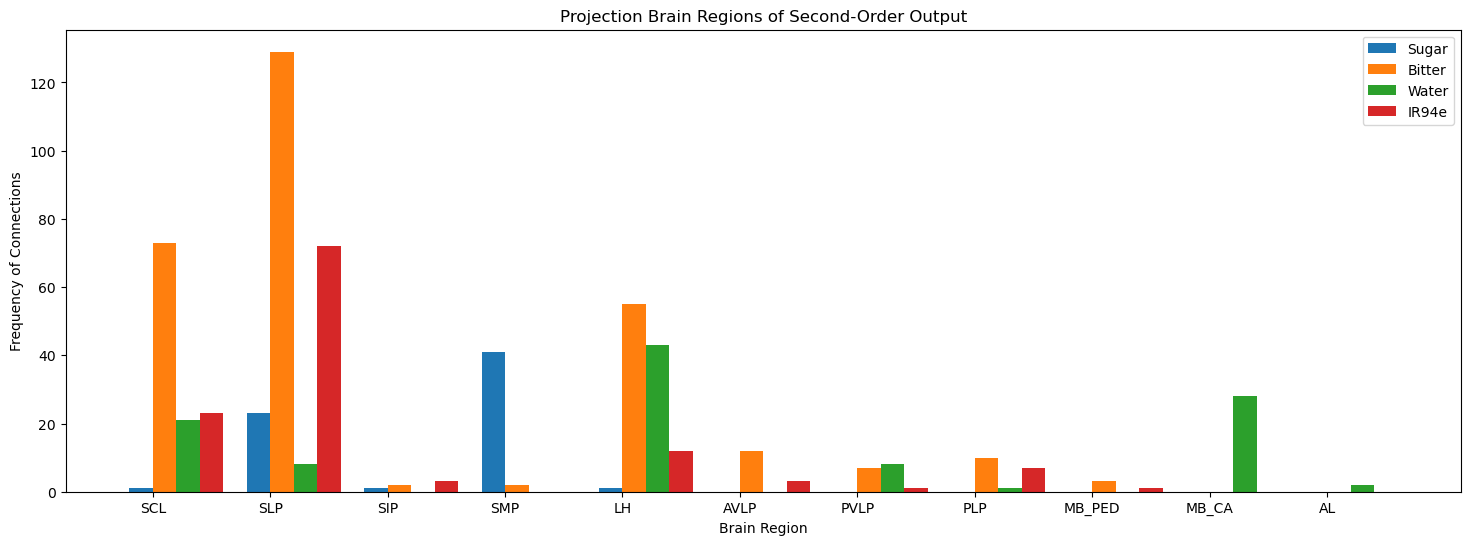

In [38]:
categories = ['SCL', 'SLP', 'SIP', 'SMP','LH','AVLP','PVLP','PLP','MB_PED','MB_CA','AL']

variable1 = [
len(sugar_third_order[sugar_third_order['neuropil'] == 'SCL_L']),
len(sugar_third_order[sugar_third_order['neuropil'] == 'SLP_L']),
len(sugar_third_order[sugar_third_order['neuropil'] == 'SIP_L']),
len(sugar_third_order[sugar_third_order['neuropil'] == 'SMP_L']),
len(sugar_third_order[sugar_third_order['neuropil'] == 'LH_L']) + len(sugar_third_order[sugar_third_order['neuropil'] == 'LH_R']),
len(sugar_third_order[sugar_third_order['neuropil'] == 'AVLP_L']),
len(sugar_third_order[sugar_third_order['neuropil'] == 'PVLP_L']),
len(sugar_third_order[sugar_third_order['neuropil'] == 'PLP_L']),
len(sugar_third_order[sugar_third_order['neuropil'] == 'MB_PED_L']),
len(sugar_third_order[sugar_third_order['neuropil'] == 'MB_CA_L']),
len(sugar_third_order[sugar_third_order['neuropil'] == 'AL_R'])]

variable2 = [
len(bitter_third_order[bitter_third_order['neuropil'] == 'SCL_L']) + len(bitter_third_order[bitter_third_order['neuropil'] == 'SCL_R']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'SLP_L']) + len(bitter_third_order[bitter_third_order['neuropil'] == 'SLP_R']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'SIP_L']) + len(bitter_third_order[bitter_third_order['neuropil'] == 'SIP_R']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'SMP_L']) + len(bitter_third_order[bitter_third_order['neuropil'] == 'SMP_R']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'LH_L']) + len(bitter_third_order[bitter_third_order['neuropil'] == 'LH_R']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'AVLP_L']) + len(bitter_third_order[bitter_third_order['neuropil'] == 'AVLP_R']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'PVLP_L']) + len(bitter_third_order[bitter_third_order['neuropil'] == 'PVLP_R']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'PLP_L']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'MB_PED_L']) + len(bitter_third_order[bitter_third_order['neuropil'] == 'MB_PED_R']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'MB_CA_L']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'AL_R'])]

variable3 = [
len(water_third_order[water_third_order['neuropil'] == 'SCL_L']),
len(water_third_order[water_third_order['neuropil'] == 'SLP_L']),
len(water_third_order[water_third_order['neuropil'] == 'SIP_L']),
len(water_third_order[water_third_order['neuropil'] == 'SMP_L']),
len(water_third_order[water_third_order['neuropil'] == 'LH_L']) + len(water_third_order[water_third_order['neuropil'] == 'LH_R']),
len(water_third_order[water_third_order['neuropil'] == 'AVLP_L']),
len(water_third_order[water_third_order['neuropil'] == 'PVLP_L']),
len(water_third_order[water_third_order['neuropil'] == 'PLP_L']),
len(water_third_order[water_third_order['neuropil'] == 'MB_PED_L']),
len(water_third_order[water_third_order['neuropil'] == 'MB_CA_L']),
len(water_third_order[water_third_order['neuropil'] == 'AL_R'])]

variable4=[
len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'SCL_L']),
len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'SLP_L']) + len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'SLP_R']),
len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'SIP_L']),
len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'SMP_L']),
len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'LH_L']) + len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'LH_R']),
len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'AVLP_L']),
len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'PVLP_L']),
len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'PLP_L']),
len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'MB_PED_L']),
len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'MB_CA_L']),
len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'AL_R'])]

x = range(len(categories))

bar_width = 0.2

plt.figure(figsize=(18, 6))
plt.bar(x, variable1, width=bar_width, label='Sugar')
plt.bar([i + bar_width for i in x], variable2, width=bar_width, label = 'Bitter')
plt.bar([i + 2*bar_width for i in x], variable3, width=bar_width, label = 'Water')
plt.bar([i + 3*bar_width for i in x], variable4, width=bar_width, label = 'IR94e')


plt.xlabel('Brain Region')
plt.ylabel('Frequency of Connections')
plt.title('Projection Brain Regions of Second-Order Output')
plt.xticks([i + bar_width / 2 for i in x], categories)
plt.legend()
plt.show()

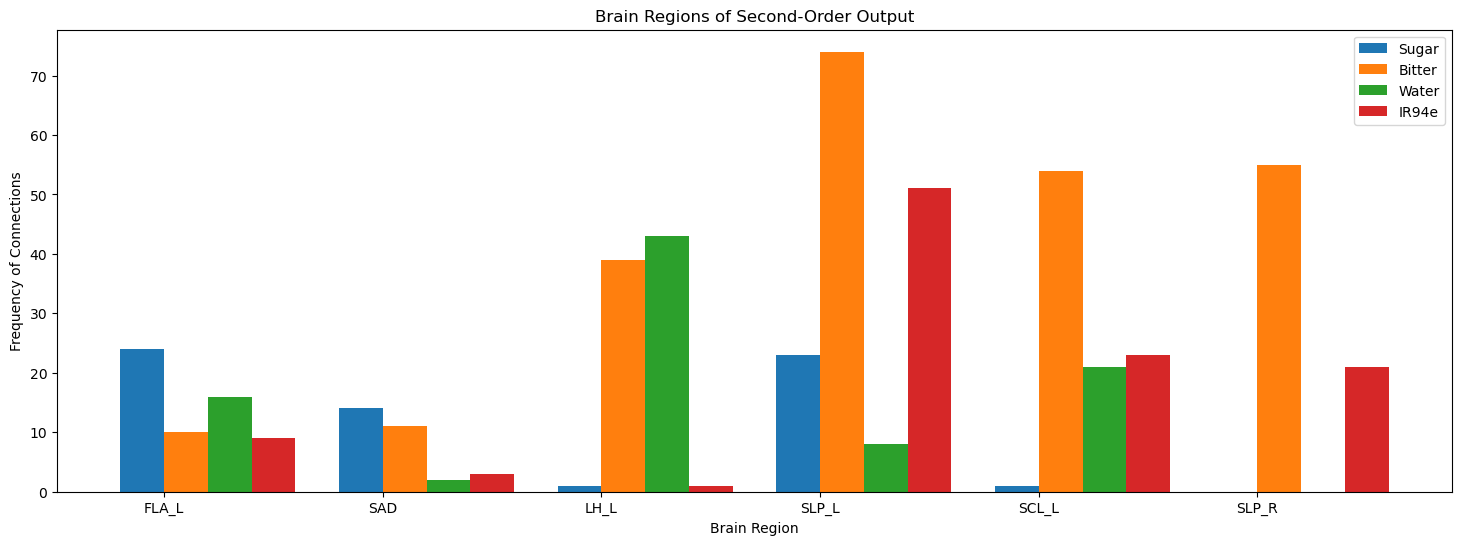

In [40]:
# Clustered bar chart of the brain region of connections for second order neurons within all taste modalities
# Threshold is atleast 10 connections for a brain region to be specified

#NEW

# categories = ['GNG', 'PRW', 'FLA_L', 'SAD', 'LH_L', 'SLP_L', 'SCL_L', 'SLP_R']
categories = ['FLA_L', 'SAD', 'LH_L', 'SLP_L', 'SCL_L', 'SLP_R']

# variable1 = [len(sugar_third_order[sugar_third_order['neuropil'] == 'GNG']),
#  len(sugar_third_order[sugar_third_order['neuropil'] == 'PRW']),
# len(sugar_third_order[sugar_third_order['neuropil'] == 'FLA_L']),
# len(sugar_third_order[sugar_third_order['neuropil'] == 'SAD']),
# len(sugar_third_order[sugar_third_order['neuropil'] == 'LH_L']),
# len(sugar_third_order[sugar_third_order['neuropil'] == 'SLP_L']),
# len(sugar_third_order[sugar_third_order['neuropil'] == 'SCL_L']),
# len(sugar_third_order[sugar_third_order['neuropil'] == 'SLP_R'])]

variable1 = [
len(sugar_third_order[sugar_third_order['neuropil'] == 'FLA_L']),
len(sugar_third_order[sugar_third_order['neuropil'] == 'SAD']),
len(sugar_third_order[sugar_third_order['neuropil'] == 'LH_L']),
len(sugar_third_order[sugar_third_order['neuropil'] == 'SLP_L']),
len(sugar_third_order[sugar_third_order['neuropil'] == 'SCL_L']),
len(sugar_third_order[sugar_third_order['neuropil'] == 'SLP_R'])]


# variable2 = [len(bitter_third_order[bitter_third_order['neuropil'] == 'GNG']),
#  len(bitter_third_order[bitter_third_order['neuropil'] == 'PRW']),
# len(bitter_third_order[bitter_third_order['neuropil'] == 'FLA_L']),
# len(bitter_third_order[bitter_third_order['neuropil'] == 'SAD']),
# len(bitter_third_order[bitter_third_order['neuropil'] == 'LH_L']),
# len(bitter_third_order[bitter_third_order['neuropil'] == 'SLP_L']),
# len(bitter_third_order[bitter_third_order['neuropil'] == 'SCL_L']),
# len(bitter_third_order[bitter_third_order['neuropil'] == 'SLP_R'])]

variable2 = [
len(bitter_third_order[bitter_third_order['neuropil'] == 'FLA_L']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'SAD']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'LH_L']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'SLP_L']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'SCL_L']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'SLP_R'])]

# variable3 = [len(water_third_order[water_third_order['neuropil'] == 'GNG']),
#  len(water_third_order[water_third_order['neuropil'] == 'PRW']),
# len(water_third_order[water_third_order['neuropil'] == 'FLA_L']),
# len(water_third_order[water_third_order['neuropil'] == 'SAD']),
# len(water_third_order[water_third_order['neuropil'] == 'LH_L']),
# len(water_third_order[water_third_order['neuropil'] == 'SLP_L']),
# len(water_third_order[water_third_order['neuropil'] == 'SCL_L']),
# len(water_third_order[water_third_order['neuropil'] == 'SLP_R'])]

variable3 = [
len(water_third_order[water_third_order['neuropil'] == 'FLA_L']),
len(water_third_order[water_third_order['neuropil'] == 'SAD']),
len(water_third_order[water_third_order['neuropil'] == 'LH_L']),
len(water_third_order[water_third_order['neuropil'] == 'SLP_L']),
len(water_third_order[water_third_order['neuropil'] == 'SCL_L']),
len(water_third_order[water_third_order['neuropil'] == 'SLP_R'])]


# variable4=[len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'GNG']),
#  len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'PRW']),
# len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'FLA_L']),
# len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'SAD']),
# len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'LH_L']),
# len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'SLP_L']),
# len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'SCL_L']),
# len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'SLP_R'])]


variable4=[
len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'FLA_L']),
len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'SAD']),
len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'LH_L']),
len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'SLP_L']),
len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'SCL_L']),
len(lowsalt_third_order[lowsalt_third_order['neuropil'] == 'SLP_R'])]

x = range(len(categories))

bar_width = 0.2

plt.figure(figsize=(18, 6))
plt.bar(x, variable1, width=bar_width, label='Sugar')
plt.bar([i + bar_width for i in x], variable2, width=bar_width, label = 'Bitter')
plt.bar([i + 2*bar_width for i in x], variable3, width=bar_width, label = 'Water')
plt.bar([i + 3*bar_width for i in x], variable4, width=bar_width, label = 'IR94e')


plt.xlabel('Brain Region')
plt.ylabel('Frequency of Connections')
plt.title('Brain Regions of Second-Order Output')
plt.xticks([i + bar_width / 2 for i in x], categories)
plt.legend()
plt.show()

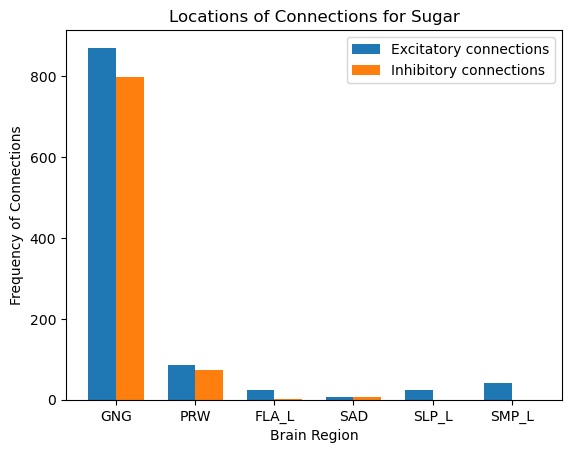

In [41]:
# Clustered bar chart of the brain region of ACH/non-ACH connections for second order sugar neurons
# Threshold is atleast 10 connections for a brain region to be specified

#NEW

categories = ['GNG', 'PRW', 'FLA_L', 'SAD', 'SLP_L', 'SMP_L']
variable1 = [len(sugar_third_order[(sugar_third_order['nt_type'] == 'ACH') & (sugar_third_order['neuropil'] == 'GNG')]),
 len(sugar_third_order[(sugar_third_order['nt_type'] == 'ACH') & (sugar_third_order['neuropil'] == 'PRW')]),
len(sugar_third_order[(sugar_third_order['nt_type'] == 'ACH') & (sugar_third_order['neuropil'] == 'FLA_L')]),
len(sugar_third_order[(sugar_third_order['nt_type'] == 'ACH') & (sugar_third_order['neuropil'] == 'SAD')]),
len(sugar_third_order[(sugar_third_order['nt_type'] == 'ACH') & (sugar_third_order['neuropil'] == 'SLP_L')]),
len(sugar_third_order[(sugar_third_order['nt_type'] == 'ACH') & (sugar_third_order['neuropil'] == 'SMP_L')])]
# variable2 = [len(sugar_third_order[sugar_third_order['neuropil'] == 'GNG']),
#  len(sugar_third_order[sugar_third_order['neuropil'] == 'PRW']),
# len(sugar_third_order[sugar_third_order['neuropil'] == 'FLA_L']),
# len(sugar_third_order[sugar_third_order['neuropil'] == 'SAD']),
# len(sugar_third_order[sugar_third_order['neuropil'] == 'SLP_L']),
# len(sugar_third_order[sugar_third_order['neuropil'] == 'SMP_L'])]

variable2 = [len(sugar_third_order[(sugar_third_order['nt_type'] != 'ACH') & (sugar_third_order['neuropil'] == 'GNG')]),
 len(sugar_third_order[(sugar_third_order['nt_type'] != 'ACH') & (sugar_third_order['neuropil'] == 'PRW')]),
len(sugar_third_order[(sugar_third_order['nt_type'] != 'ACH') & (sugar_third_order['neuropil'] == 'FLA_L')]),
len(sugar_third_order[(sugar_third_order['nt_type'] != 'ACH') & (sugar_third_order['neuropil'] == 'SAD')]),
len(sugar_third_order[(sugar_third_order['nt_type'] != 'ACH') & (sugar_third_order['neuropil'] == 'SLP_L')]),
len(sugar_third_order[(sugar_third_order['nt_type'] != 'ACH') & (sugar_third_order['neuropil'] == 'SMP_L')])]

x = range(len(categories))

bar_width = 0.35

plt.bar(x, variable1, width=bar_width, label='Variable 1')
plt.bar([i + bar_width for i in x], variable2, width=bar_width, label = 'variable2')

plt.xlabel('Brain Region')
plt.ylabel('Frequency of Connections')
plt.title('Locations of Connections for Sugar')
plt.xticks([i + bar_width / 2 for i in x], categories)
plt.legend(labels=['Excitatory connections', 'Inhibitory connections'])
plt.show()

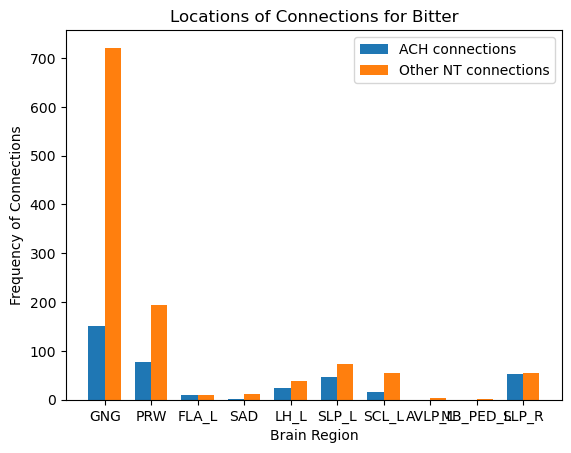

In [42]:
# Clustered bar chart of the brain region of ACH/non-ACH connections for second order bitter neurons
# Threshold is atleast 10 connections for a brain region to be specified

#NEW

categories = ['GNG', 'PRW', 'FLA_L', 'SAD', 'LH_L', 'SLP_L', 'SCL_L', 'AVLP_L','MB_PED_L','SLP_R']
variable1 = [len(bitter_third_order[(bitter_third_order['nt_type'] == 'ACH') & (bitter_third_order['neuropil'] == 'GNG')]),
len(bitter_third_order[(bitter_third_order['nt_type'] == 'ACH') & (bitter_third_order['neuropil'] == 'PRW')]),
len(bitter_third_order[(bitter_third_order['nt_type'] == 'ACH') & (bitter_third_order['neuropil'] == 'FLA_L')]),
len(bitter_third_order[(bitter_third_order['nt_type'] == 'ACH') & (bitter_third_order['neuropil'] == 'SAD')]),
len(bitter_third_order[(bitter_third_order['nt_type'] == 'ACH') & (bitter_third_order['neuropil'] == 'LH_L')]),
len(bitter_third_order[(bitter_third_order['nt_type'] == 'ACH') & (bitter_third_order['neuropil'] == 'SLP_L')]),
len(bitter_third_order[(bitter_third_order['nt_type'] == 'ACH') & (bitter_third_order['neuropil'] == 'SCL_L')]),
len(bitter_third_order[(bitter_third_order['nt_type'] == 'ACH') & (bitter_third_order['neuropil'] == 'AVLP_L')]),
len(bitter_third_order[(bitter_third_order['nt_type'] == 'ACH') & (bitter_third_order['neuropil'] == 'MB_PED_L')]),
len(bitter_third_order[(bitter_third_order['nt_type'] == 'ACH') & (bitter_third_order['neuropil'] == 'SLP_R')])]
variable2 = [len(bitter_third_order[bitter_third_order['neuropil'] == 'GNG']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'PRW']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'FLA_L']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'SAD']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'LH_L']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'SLP_L']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'SCL_L']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'AVLP_L']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'MB_PED_L']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'SLP_R'])]

x = range(len(categories))

bar_width = 0.35

plt.bar(x, variable1, width=bar_width, label='ACH connections')
plt.bar([i + bar_width for i in x], variable2, width=bar_width, label = 'Other NT connections')

plt.xlabel('Brain Region')
plt.ylabel('Frequency of Connections')
plt.title('Locations of Connections for Bitter')
plt.xticks([i + bar_width / 2 for i in x], categories)
plt.legend()
plt.show()

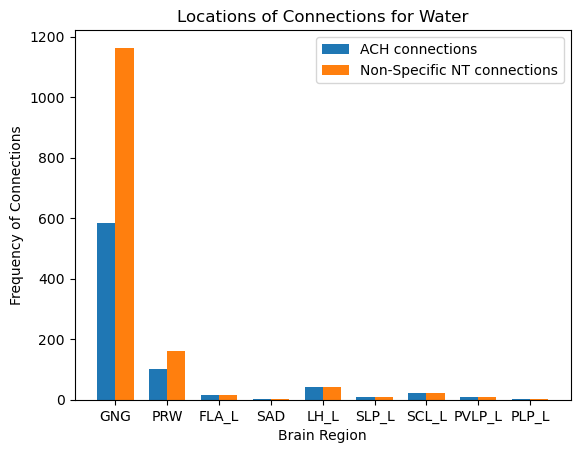

In [43]:
# Clustered bar chart of the brain region of ACH/non-ACH connections for second order water neurons
# Threshold is atleast 10 connections for a brain region to be specified

#NEW

categories = ['GNG', 'PRW', 'FLA_L', 'SAD', 'LH_L', 'SLP_L', 'SCL_L', 'PVLP_L','PLP_L']
variable1 = [len(water_third_order[(water_third_order['nt_type'] == 'ACH') & (water_third_order['neuropil'] == 'GNG')]),
len(water_third_order[(water_third_order['nt_type'] == 'ACH') & (water_third_order['neuropil'] == 'PRW')]),
len(water_third_order[(water_third_order['nt_type'] == 'ACH') & (water_third_order['neuropil'] == 'FLA_L')]),
len(water_third_order[(water_third_order['nt_type'] == 'ACH') & (water_third_order['neuropil'] == 'SAD')]),
len(water_third_order[(water_third_order['nt_type'] == 'ACH') & (water_third_order['neuropil'] == 'LH_L')]),
len(water_third_order[(water_third_order['nt_type'] == 'ACH') & (water_third_order['neuropil'] == 'SLP_L')]),
len(water_third_order[(water_third_order['nt_type'] == 'ACH') & (water_third_order['neuropil'] == 'SCL_L')]),
len(water_third_order[(water_third_order['nt_type'] == 'ACH') & (water_third_order['neuropil'] == 'PVLP_L')]),
len(water_third_order[(water_third_order['nt_type'] == 'ACH') & (water_third_order['neuropil'] == 'PLP_L')])]
# variable2 = [len(water_third_order[(water_third_order['nt_type'] != 'ACH') & (water_third_order['neuropil'] == 'GNG')]),
# len(water_third_order[(water_third_order['nt_type'] != 'ACH') & (water_third_order['neuropil'] == 'PRW')]),
# len(water_third_order[(water_third_order['nt_type'] != 'ACH') & (water_third_order['neuropil'] == 'FLA_L')]),
# len(water_third_order[(water_third_order['nt_type'] != 'ACH') & (water_third_order['neuropil'] == 'SAD')]),
# len(water_third_order[(water_third_order['nt_type'] != 'ACH') & (water_third_order['neuropil'] == 'LH_L')]),
# len(water_third_order[(water_third_order['nt_type'] != 'ACH') & (water_third_order['neuropil'] == 'SLP_L')]),
# len(water_third_order[(water_third_order['nt_type'] != 'ACH') & (water_third_order['neuropil'] == 'SCL_L')]),
# len(water_third_order[(water_third_order['nt_type'] != 'ACH') & (water_third_order['neuropil'] == 'PVLP_L')]),
# len(water_third_order[(water_third_order['nt_type'] != 'ACH') & (water_third_order['neuropil'] == 'PLP_L')])]

variable2 = [len(water_third_order[water_third_order['neuropil'] == 'GNG']),
len(water_third_order[water_third_order['neuropil'] == 'PRW']),
len(water_third_order[water_third_order['neuropil'] == 'FLA_L']),
len(water_third_order[water_third_order['neuropil'] == 'SAD']),
len(water_third_order[water_third_order['neuropil'] == 'LH_L']),
len(water_third_order[water_third_order['neuropil'] == 'SLP_L']),
len(water_third_order[water_third_order['neuropil'] == 'SCL_L']),
len(water_third_order[water_third_order['neuropil'] == 'PVLP_L']),
len(water_third_order[water_third_order['neuropil'] == 'PLP_L'])]


x = range(len(categories))

bar_width = 0.35

plt.bar(x, variable1, width=bar_width, label='Variable 1')
plt.bar([i + bar_width for i in x], variable2, width=bar_width, label = 'variable2')

plt.xlabel('Brain Region')
plt.ylabel('Frequency of Connections')
plt.title('Locations of Connections for Water')
plt.xticks([i + bar_width / 2 for i in x], categories)
plt.legend(labels=['ACH connections', 'Non-Specific NT connections'])
plt.show()

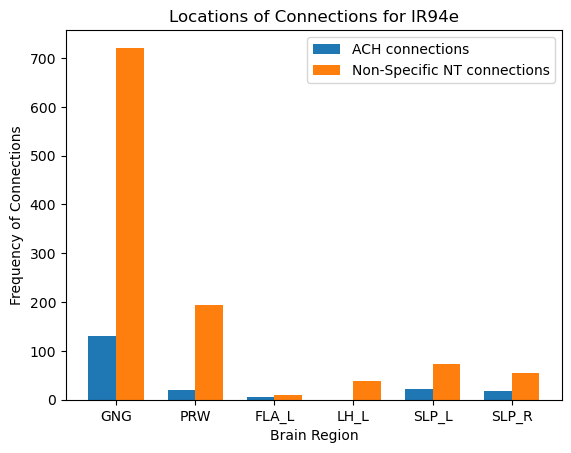

In [44]:
# Clustered bar chart of the brain region of ACH/non-ACH connections for second order IR94e neurons
# Threshold is atleast 10 connections for a brain region to be specified

#NEW

categories = ['GNG', 'PRW', 'FLA_L', 'LH_L', 'SLP_L', 'SLP_R']
variable1 = [len(lowsalt_third_order[(lowsalt_third_order['nt_type'] == 'ACH') & (lowsalt_third_order['neuropil'] == 'GNG')]),
len(lowsalt_third_order[(lowsalt_third_order['nt_type'] == 'ACH') & (lowsalt_third_order['neuropil'] == 'PRW')]),
len(lowsalt_third_order[(lowsalt_third_order['nt_type'] == 'ACH') & (lowsalt_third_order['neuropil'] == 'FLA_L')]),
len(lowsalt_third_order[(lowsalt_third_order['nt_type'] == 'ACH') & (lowsalt_third_order['neuropil'] == 'LH_L')]),
len(lowsalt_third_order[(lowsalt_third_order['nt_type'] == 'ACH') & (lowsalt_third_order['neuropil'] == 'SLP_L')]),
len(lowsalt_third_order[(lowsalt_third_order['nt_type'] == 'ACH') & (lowsalt_third_order['neuropil'] == 'SLP_R')])]
variable2 = [len(bitter_third_order[bitter_third_order['neuropil'] == 'GNG']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'PRW']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'FLA_L']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'LH_L']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'SLP_L']),
len(bitter_third_order[bitter_third_order['neuropil'] == 'SLP_R'])]

x = range(len(categories))

bar_width = 0.35

plt.bar(x, variable1, width=bar_width, label='Variable 1')
plt.bar([i + bar_width for i in x], variable2, width=bar_width, label = 'variable2')

plt.xlabel('Brain Region')
plt.ylabel('Frequency of Connections')
plt.title('Locations of Connections for IR94e')
plt.xticks([i + bar_width / 2 for i in x], categories)
plt.legend(labels=['ACH connections', 'Non-Specific NT connections'])
plt.show()

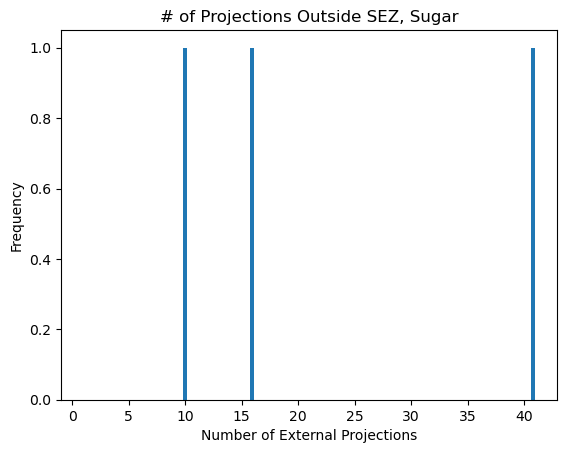

In [45]:
# To see if the ones being classified as non-local only had one external projection!!!
# Quantifying the number of external projections for each sugar 2N
# Outputs a bargraph of the spread

data = sugar_second_order_projection['#_of_external_projections']

num_bins = len(sugar_second_order_projection)
bins = np.linspace(1, max(data), num_bins + 1)
frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
plt.bar(bin_labels, frequencies, width=(max(data) - min(data)) / num_bins * 0.8, align='center')
plt.xlabel('Number of External Projections')
plt.ylabel('Frequency')
plt.title('# of Projections Outside SEZ, Sugar')
plt.show()

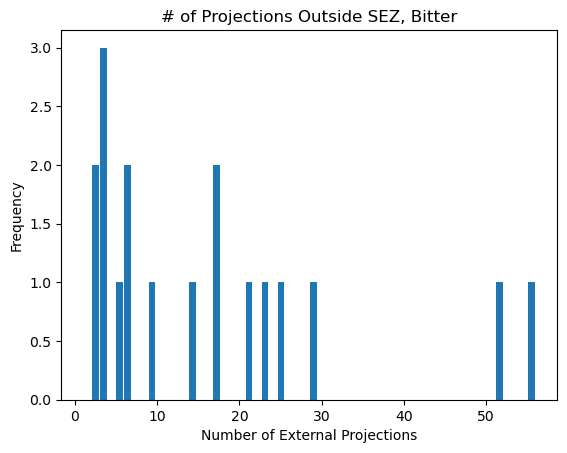

In [46]:
# Quantifying the number of external projections for each bitter 2N
# Outputs a bargraph of the spread

data = bitter_second_order_projection['#_of_external_projections']

num_bins = len(bitter_second_order_projection)
bins = np.linspace(1, max(data), num_bins + 1)
frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
plt.bar(bin_labels, frequencies, width=(max(data) - min(data)) / num_bins * 0.8, align='center')
plt.xlabel('Number of External Projections')
plt.ylabel('Frequency')
plt.title('# of Projections Outside SEZ, Bitter')
plt.show()

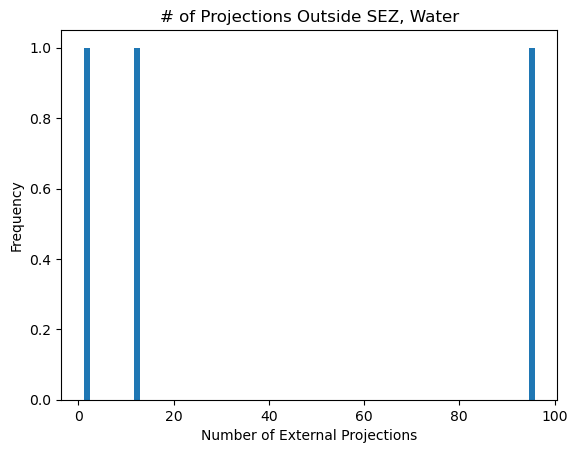

In [47]:
# Quantifying the number of external projections for each water 2N
# Outputs a bargraph of the spread

data = water_second_order_projection['#_of_external_projections']

num_bins = len(water_second_order_projection)
bins = np.linspace(1, max(data), num_bins + 1)
frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
plt.bar(bin_labels, frequencies, width=(max(data) - min(data)) / num_bins * 0.8, align='center')
plt.xlabel('Number of External Projections')
plt.ylabel('Frequency')
plt.title('# of Projections Outside SEZ, Water')
plt.show()

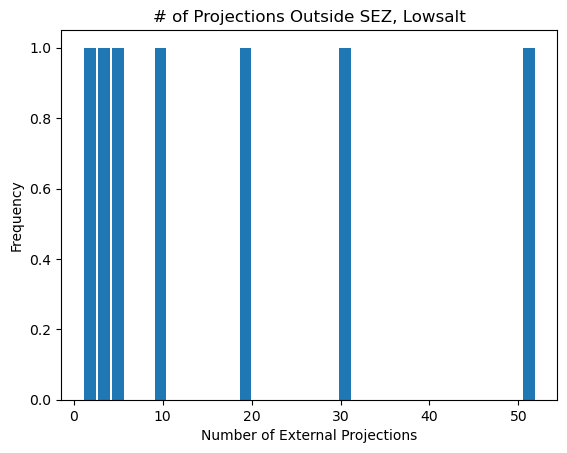

In [48]:
# Quantifying the number of external projections for each IR94e 2N
# Outputs a bargraph of the spread

data = lowsalt_second_order_projection['#_of_external_projections']

num_bins = len(lowsalt_second_order_projection)
bins = np.linspace(1, max(data), num_bins + 1)
frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
plt.bar(bin_labels, frequencies, width=(max(data) - min(data)) / num_bins * 0.8, align='center')
plt.xlabel('Number of External Projections')
plt.ylabel('Frequency')
plt.title('# of Projections Outside SEZ, Lowsalt')
plt.show()

In [49]:
import pandas as pd

def calculate_sum(df):
    return len(df)

dfs = [sugar_third_order, bitter_third_order, water_third_order, lowsalt_third_order]
sums = [calculate_sum(df) for df in dfs]
sum_sugars, sum_bitters, sum_waters, sum_lowsalts = sums


def calculate_proportions(dfs, nt_types):
    proportions = {}
    for nt_type in nt_types:
        proportions[nt_type] = []
        for df in dfs:
            if nt_type == "Other":
                count = len(df.query("nt_type != 'ACH' & nt_type != 'GABA' & nt_type != 'GLUT'"))
            else:
                count = len(df.query(f"nt_type == '{nt_type}'"))
            total = len(df)
            proportion = count / total if total > 0 else 0
            proportions[nt_type].append(proportion)
        proportions[nt_type] = np.array(proportions[nt_type])
    return proportions

dfs = [sugar_third_order, bitter_third_order, water_third_order, lowsalt_third_order]
nt_types = ["ACH", "GABA", "GLUT", "Other"]
proportion_inputs = calculate_proportions(dfs, nt_types)

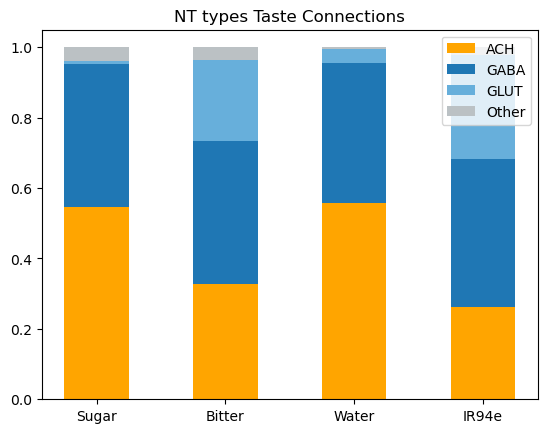

In [50]:
# Identifying which NTs are involved in local CONNECTIONS
# This function outputs a bar graph of the NT types for CONNECTIONS
# NEW

modalities = (
    'Sugar',
    'Bitter',
    'Water',
    'IR94e')

sum_sugar = len(sugar_third_order.query("nt_type == 'ACH'")) + len(sugar_third_order.query("nt_type == 'GABA'")) + len(sugar_third_order.query("nt_type == 'GLUT'")) + len(sugar_third_order.query("nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))
sum_bitter = len(bitter_third_order.query("nt_type == 'ACH'")) + len(bitter_third_order.query("nt_type == 'GABA'")) + len(bitter_third_order.query("nt_type == 'GLUT'")) + len(bitter_third_order.query("nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))
sum_water = len(water_third_order.query("nt_type == 'ACH'")) + len(water_third_order.query("nt_type == 'GABA'")) + len(water_third_order.query("nt_type == 'GLUT'")) + len(water_third_order.query("nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))
sum_lowsalt = len(lowsalt_third_order.query("nt_type == 'ACH'")) + len(lowsalt_third_order.query("nt_type == 'GABA'")) + len(lowsalt_third_order.query("nt_type == 'GLUT'")) + len(lowsalt_third_order.query("nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))

proportion_inputs = {
    "ACH": np.array([len(sugar_third_order.query("nt_type == 'ACH'"))/sum_sugar,len(bitter_third_order.query("nt_type == 'ACH'"))/sum_bitter,len(water_third_order.query("nt_type == 'ACH'"))/sum_water,len(lowsalt_third_order.query("nt_type == 'ACH'"))/sum_lowsalt]),
    "GABA": np.array([len(sugar_third_order.query("nt_type == 'GABA'"))/sum_sugar,len(bitter_third_order.query("nt_type == 'GABA'"))/sum_bitter,len(water_third_order.query("nt_type == 'GABA'"))/sum_water,len(lowsalt_third_order.query("nt_type == 'GABA'"))/sum_lowsalt]),
    "GLUT": np.array([len(sugar_third_order.query("nt_type == 'GLUT'"))/sum_sugar,len(bitter_third_order.query("nt_type == 'GLUT'"))/sum_bitter,len(water_third_order.query("nt_type == 'GLUT'"))/sum_water,len(lowsalt_third_order.query("nt_type == 'GLUT'"))/sum_lowsalt]),
    "Other": np.array([len(sugar_third_order.query("nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))/sum_sugar,len(bitter_third_order.query("nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))/sum_bitter,len(water_third_order.query("nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))/sum_water,len(lowsalt_third_order.query("nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))/sum_lowsalt])
}

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(4)

colors = ['orange', '#1f77b4', '#67afdb', '#bbc1c4']

for boolean, proportion_input, color in zip(proportion_inputs.keys(), proportion_inputs.values(), colors):
    p = ax.bar(modalities, proportion_input, width, label=boolean, bottom=bottom, color = color)
    bottom += proportion_input

ax.set_title("NT types Taste Connections")
ax.legend(loc="upper right")

plt.show()

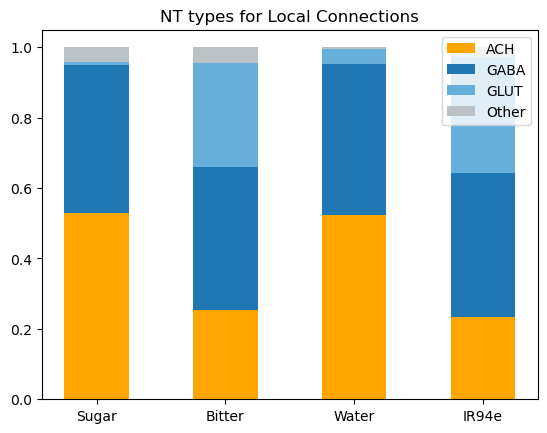

In [51]:
# Identifying which NTs are involved in local CONNECTIONS
# This function outputs a bar graph of the NT types for local CONNECTIONS
# NEW

modalities = (
    'Sugar',
    'Bitter',
    'Water',
    'IR94e')

sum_sugar = len(sugar_third_order.query("location_of_connection == 'local' and nt_type == 'ACH'")) + len(sugar_third_order.query("location_of_connection == 'local' and nt_type == 'GABA'")) + len(sugar_third_order.query("location_of_connection == 'local' and nt_type == 'GLUT'")) + len(sugar_third_order.query("location_of_connection == 'local' & nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))
sum_bitter = len(bitter_third_order.query("location_of_connection == 'local' and nt_type == 'ACH'")) + len(bitter_third_order.query("location_of_connection == 'local' and nt_type == 'GABA'")) + len(bitter_third_order.query("location_of_connection == 'local' and nt_type == 'GLUT'")) + len(bitter_third_order.query("location_of_connection == 'local' & nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))
sum_water = len(water_third_order.query("location_of_connection == 'local' and nt_type == 'ACH'")) + len(water_third_order.query("location_of_connection == 'local' and nt_type == 'GABA'")) + len(water_third_order.query("location_of_connection == 'local' and nt_type == 'GLUT'")) + len(water_third_order.query("location_of_connection == 'local' & nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))
sum_lowsalt = len(lowsalt_third_order.query("location_of_connection == 'local' and nt_type == 'ACH'")) + len(lowsalt_third_order.query("location_of_connection == 'local' and nt_type == 'GABA'")) + len(lowsalt_third_order.query("location_of_connection == 'local' and nt_type == 'GLUT'")) + len(lowsalt_third_order.query("location_of_connection == 'local' & nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))

proportion_inputs = {
    "ACH": np.array([len(sugar_third_order.query("location_of_connection == 'local' and nt_type == 'ACH'"))/sum_sugar,len(bitter_third_order.query("location_of_connection == 'local' and nt_type == 'ACH'"))/sum_bitter,len(water_third_order.query("location_of_connection == 'local' and nt_type == 'ACH'"))/sum_water,len(lowsalt_third_order.query("location_of_connection == 'local' and nt_type == 'ACH'"))/sum_lowsalt]),
    "GABA": np.array([len(sugar_third_order.query("location_of_connection == 'local' and nt_type == 'GABA'"))/sum_sugar,len(bitter_third_order.query("location_of_connection == 'local' and nt_type == 'GABA'"))/sum_bitter,len(water_third_order.query("location_of_connection == 'local' and nt_type == 'GABA'"))/sum_water,len(lowsalt_third_order.query("location_of_connection == 'local' and nt_type == 'GABA'"))/sum_lowsalt]),
    "GLUT": np.array([len(sugar_third_order.query("location_of_connection == 'local' and nt_type == 'GLUT'"))/sum_sugar,len(bitter_third_order.query("location_of_connection == 'local' and nt_type == 'GLUT'"))/sum_bitter,len(water_third_order.query("location_of_connection == 'local' and nt_type == 'GLUT'"))/sum_water,len(lowsalt_third_order.query("location_of_connection == 'local' and nt_type == 'GLUT'"))/sum_lowsalt]),
    "Other": np.array([len(sugar_third_order.query("location_of_connection == 'local' & nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))/sum_sugar,len(bitter_third_order.query("location_of_connection == 'local' & nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))/sum_bitter,len(water_third_order.query("location_of_connection == 'local' & nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))/sum_water,len(lowsalt_third_order.query("location_of_connection == 'local' & nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))/sum_lowsalt])
}

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(4)

colors = ['orange', '#1f77b4', '#67afdb', '#bbc1c4']

for boolean, proportion_input, color in zip(proportion_inputs.keys(), proportion_inputs.values(), colors):
    p = ax.bar(modalities, proportion_input, width, label=boolean, bottom=bottom, color = color)
    bottom += proportion_input

ax.set_title("NT types for Local Connections")
ax.legend(loc="upper right")

plt.show()

In [52]:
print(sum_sugar, sum_water, sum_bitter, sum_lowsalt)
print(proportion_inputs)

1868 1342 938 670
{'ACH': array([0.52890792, 0.25479744, 0.52235469, 0.23283582]), 'GABA': array([0.42184154, 0.40618337, 0.4314456 , 0.41044776]), 'GLUT': array([0.00749465, 0.29317697, 0.04023845, 0.32985075]), 'Other': array([0.04175589, 0.04584222, 0.00596125, 0.02686567])}


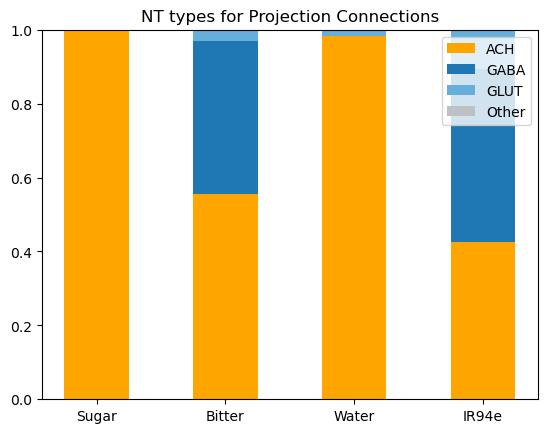

In [53]:
# Identifying which NTs are involved in projection CONNECTIONS
# This function outputs a bar graph of the NT types for projection CONNECTIONS
# NEW

modalities = (
    'Sugar',
    'Bitter',
    'Water',
    'IR94e')

sum_sugar = len(sugar_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'ACH'")) + len(sugar_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GABA'")) + len(sugar_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GLUT'")) + len(sugar_third_order.query("location_of_connection == 'outside_SEZ' & nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))
sum_bitter = len(bitter_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'ACH'")) + len(bitter_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GABA'")) + len(bitter_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GLUT'")) + len(bitter_third_order.query("location_of_connection == 'outside_SEZ' & nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))
sum_water = len(water_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'ACH'")) + len(water_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GABA'")) + len(water_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GLUT'")) + len(water_third_order.query("location_of_connection == 'outside_SEZ' & nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))
sum_lowsalt = len(lowsalt_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'ACH'")) + len(lowsalt_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GABA'")) + len(lowsalt_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GLUT'")) + len(lowsalt_third_order.query("location_of_connection == 'outside_SEZ' & nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))

proportion_inputs = {
    "ACH": np.array([len(sugar_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'ACH'"))/sum_sugar,len(bitter_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'ACH'"))/sum_bitter,len(water_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'ACH'"))/sum_water,len(lowsalt_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'ACH'"))/sum_lowsalt]),
    "GABA": np.array([len(sugar_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GABA'"))/sum_sugar,len(bitter_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GABA'"))/sum_bitter,len(water_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GABA'"))/sum_water,len(lowsalt_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GABA'"))/sum_lowsalt]),
    "GLUT": np.array([len(sugar_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GLUT'"))/sum_sugar,len(bitter_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GLUT'"))/sum_bitter,len(water_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GLUT'"))/sum_water,len(lowsalt_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GLUT'"))/sum_lowsalt]),
    "Other": np.array([len(sugar_third_order.query("location_of_connection == 'outside_SEZ' & nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))/sum_sugar,len(bitter_third_order.query("location_of_connection == 'outside_SEZ' & nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))/sum_bitter,len(water_third_order.query("location_of_connection == 'outside_SEZ' & nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))/sum_water,len(lowsalt_third_order.query("location_of_connection == 'outside_SEZ' & nt_type != 'GLUT' & nt_type != 'ACH' & nt_type != 'GABA'"))/sum_lowsalt])
}

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(4)

colors = ['orange', '#1f77b4', '#67afdb', '#bbc1c4']

for boolean, proportion_input, color in zip(proportion_inputs.keys(), proportion_inputs.values(), colors):
    p = ax.bar(modalities, proportion_input, width, label=boolean, bottom=bottom, color = color)
    bottom += proportion_input

ax.set_title("NT types for Projection Connections")
ax.legend(loc="upper right")

plt.show()

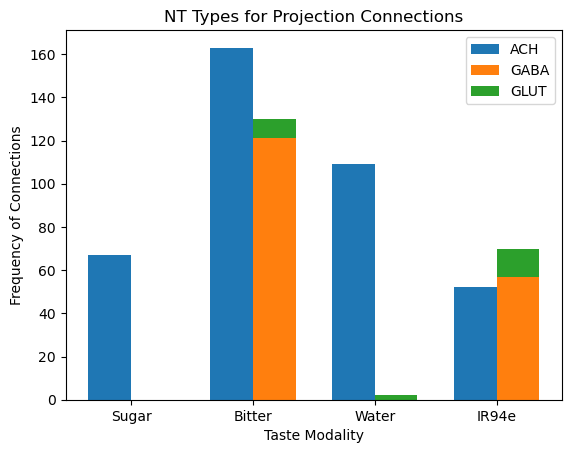

In [54]:
# Identifying which NTs are involved in projection CONNECTIONS
# This function outputs a bar graph of the NT types for projection CONNECTIONS
# NEW

categories = ['Sugar','Bitter','Water','IR94e']
variable1 = [len(sugar_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'ACH'")),
             len(bitter_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'ACH'")),
             len(water_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'ACH'")),
             len(lowsalt_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'ACH'"))]
variable2 = [len(sugar_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GABA'")),
             len(bitter_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GABA'")),
             len(water_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GABA'")),
             len(lowsalt_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GABA'"))]
variable3 = [len(sugar_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GLUT'")),
             len(bitter_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GLUT'")),
             len(water_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GLUT'")),
             len(lowsalt_third_order.query("location_of_connection == 'outside_SEZ' and nt_type == 'GLUT'"))]

x = range(len(categories))

bar_width = 0.35

plt.bar(x, variable1, width=bar_width,label = "ACH")
plt.bar([i+ bar_width for i in x], variable2, width=bar_width, label = "GABA")
plt.bar([i+ bar_width for i in x], variable3, width=bar_width, bottom= variable2, label = "GLUT")
plt.xlabel('Taste Modality')
plt.ylabel('Frequency of Connections')
plt.title('NT Types for Projection Connections')
plt.xticks([i + bar_width / 2 for i in x], categories)
plt.legend()
plt.show()

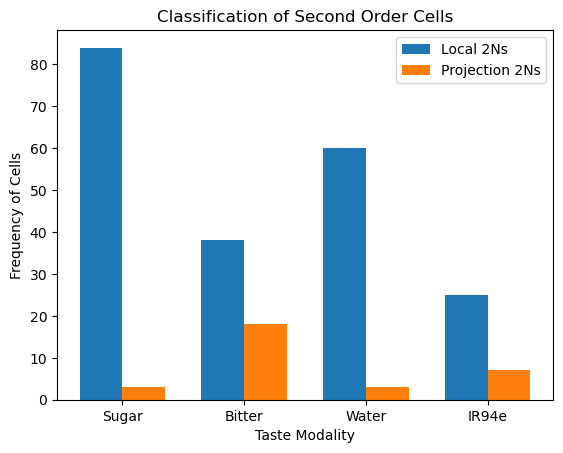

In [55]:
# Identifying the % of local/non-local second to third order CELLS for all tastes
# NEW

categories = ['Sugar','Bitter','Water','IR94e']
variable1 = [len(sugar_second_order_projection.query("projection == 'local'")),
             len(bitter_second_order_projection.query("projection == 'local'")),
             len(water_second_order_projection.query("projection == 'local'")),
             len(lowsalt_second_order_projection.query("projection == 'local'"))]
variable2 = [len(sugar_second_order_projection.query("projection == 'outside_SEZ'")),
             len(bitter_second_order_projection.query("projection == 'outside_SEZ'")),
             len(water_second_order_projection.query("projection == 'outside_SEZ'")),
             len(lowsalt_second_order_projection.query("projection == 'outside_SEZ'"))]

x = range(len(categories))

bar_width = 0.35

plt.bar(x, variable1, width=bar_width,label = "Local 2Ns")
plt.bar([i+ bar_width for i in x], variable2, width=bar_width, label = "Projection 2Ns")

plt.xlabel('Taste Modality')
plt.ylabel('Frequency of Cells')
plt.title('Classification of Second Order Cells')
plt.xticks([i + bar_width / 2 for i in x], categories)
plt.legend()
plt.show()

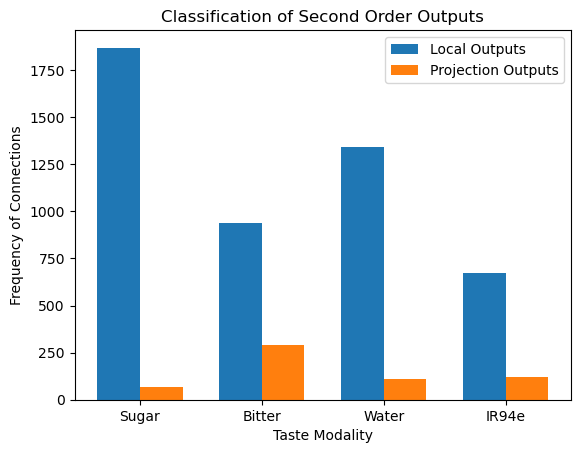

In [56]:
# Identifying the % of local/non-local second to third order CONNECTIONS for all tastes
# NEW

categories = ['Sugar','Bitter','Water','IR94e']
variable1 = [len(sugar_third_order.query("location_of_connection == 'local'")),
             len(bitter_third_order.query("location_of_connection == 'local'")),
             len(water_third_order.query("location_of_connection == 'local'")),
             len(lowsalt_third_order.query("location_of_connection == 'local'"))]
variable2 = [len(sugar_third_order.query("location_of_connection == 'outside_SEZ'")),
             len(bitter_third_order.query("location_of_connection == 'outside_SEZ'")),
             len(water_third_order.query("location_of_connection == 'outside_SEZ'")),
             len(lowsalt_third_order.query("location_of_connection == 'outside_SEZ'"))]

x = range(len(categories))

bar_width = 0.35

plt.bar(x, variable1, width=bar_width,label = "Local Outputs")
plt.bar([i+ bar_width for i in x], variable2, width=bar_width, label = "Projection Outputs")

plt.xlabel('Taste Modality')
plt.ylabel('Frequency of Connections')
plt.title('Classification of Second Order Outputs')
plt.xticks([i + bar_width / 2 for i in x], categories)
plt.legend()
plt.show()

## 2N TO 3N CONNECTIONS

In [57]:
# Function that tells us the distribution of NTs involved in 2N to 3N connections

def nt_connections(taste_third_order):
    connections = pd.DataFrame(columns = ['nt_type', '%_input'])
    unique_values = taste_third_order['nt_type'].unique()
    x = [pd.DataFrame({'nt_type': [entry], '%_input': len(taste_third_order[taste_third_order['nt_type'] == entry ])/len(taste_third_order)*100}) for entry in unique_values]
    connections = pd.concat(x, ignore_index = True)
    return connections

sugar_3N_NTs = nt_connections(sugar_third_order)
bitter_3N_NTs = nt_connections(bitter_third_order)
water_3N_NTs = nt_connections(water_third_order)
lowsalt_3N_NTs = nt_connections(lowsalt_third_order)

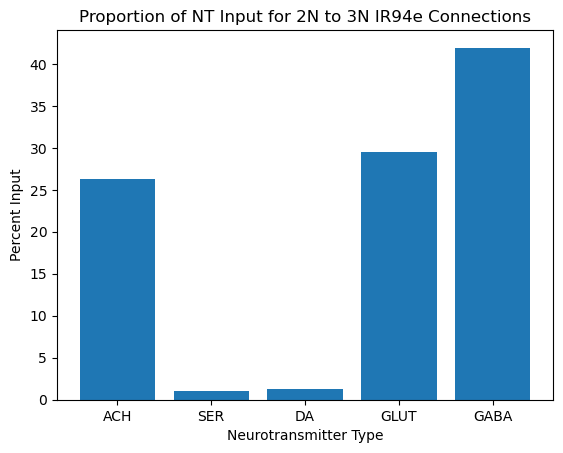

In [58]:
# NTs involved in 2N to 3N IR94e connections

plt.bar(lowsalt_3N_NTs['nt_type'], lowsalt_3N_NTs['%_input'])
plt.xlabel("Neurotransmitter Type")
plt.ylabel("Percent Input")
plt.title("Proportion of NT Input for 2N to 3N IR94e Connections")
plt.show()

In [59]:
# Defines a function that gives us information about 2N to 3N connections
# Tells us the proportion of non-local connections for each 2N

def threshold(taste_third_order):
    groups = taste_third_order.groupby("second_order_cell_ID")
    taste_third_order["#_outside_connections"] = groups["location_of_connection"].transform(lambda x: (x == "outside_SEZ").sum())
    taste_third_order["total_connections"] = groups["location_of_connection"].transform("count")
    taste_third_order["fraction_nonlocal"] = taste_third_order["#_outside_connections"] / taste_third_order["total_connections"]
    test = taste_third_order 
    test2 = test.drop_duplicates(subset = 'second_order_cell_ID').reset_index(drop=True)
    test2 = test2.drop(columns=['third_order_cell_ID','neuropil','syn_count','nt_type','location_of_connection'])
    return test2

sugar_threshold = threshold(sugar_third_order)
bitter_threshold = threshold(bitter_third_order)
water_threshold = threshold(water_third_order)
lowsalt_threshold = threshold(lowsalt_third_order)

## THIRD ORDERS

### Looking at third order cells for IR94e modality
This code identifies the third order IR94e cells and tells us whether their synapse connections to second order IR94e cells are within the SEZ

In [60]:
# Creating a funtion to classify whether connections are within or outside of the SEZ

def projection(neuropil):
    if neuropil in ['GNG', 'PRW', 'SAD', 'FLA_L', 'FLA_R']:
        return 'local'
    else:
        return 'outside_SEZ'

In [61]:
# Second to third order connections for IR94e

third_order_connections = (pd.merge(lowsalt_labels2[['second_order_cell_ID','label']], connections, left_on='second_order_cell_ID', right_on='pre_root_id', how = 'inner').query("syn_count >=5"))
third_order_connections['projection'] = third_order_connections['neuropil'].apply(projection)
third_order_connections = third_order_connections.drop(columns=['pre_root_id'])
third_order_connections = third_order_connections.rename(columns={'post_root_id':'third_order_cell_ID','label':'second_order_cell_label'})

### Identifying third order neurons for all modalities

This code will provide information about third order order GRNs and their
- second order cells their connected to 
- the synapse count for each connection
- the neurotransmitter type involved in each connection
- the location of each connection 
- the number of upstream second order cells
- the variation in NT type for upstream connections

Threshold for a neuron to be identified as third order: 5 synapses


In [62]:
# This function will output second to third order connections, synapse count and their location
# Minimum number of synapses = 5

def third_order(neuron_data, connections_dataset, taste_GRNs):
    for entry in neuron_data['second_order_cell_ID']:
        if entry in taste_GRNs['root_id']:
            pass
        else:
            merge = pd.merge(neuron_data[['second_order_cell_ID','label']], connections, left_on='second_order_cell_ID', right_on='pre_root_id', how = 'inner').query("syn_count >=10")
        merge = merge.drop(columns = 'pre_root_id')
        merge = merge.rename(columns={'post_root_id':'third_order_cell_ID','label':'second_order_cell_label'})
        def projection(neuropil):
            if neuropil in ['GNG', 'PRW', 'SAD', 'FLA_L', 'FLA_R']:
                return 'local'
            else: 
                return 'outside_SEZ'
        merge['location_of_connection'] = merge['neuropil'].apply(projection)
        return merge

In [63]:
sugar_data = sugar_data[sugar_data['#_input_sugar_synapses'] >= 10]
bitter_data = bitter_data[bitter_data['#_input_bitter_synapses'] >= 10]
water_data = water_data[water_data['#_input_water_synapses'] >= 10]
lowsalt_data = lowsalt_data[lowsalt_data['#_input_lowsalt_synapses'] >= 10]

In [64]:
# Second to third order connections, synapse count and their location

sugar_third_order = third_order(sugar_data, connections, sugar_GRNs)
bitter_third_order = third_order(bitter_data, connections, bitter_GRNs)
water_third_order = third_order(water_data, connections, water_GRNs)
lowsalt_third_order = third_order(lowsalt_data, connections, lowsalt_GRNs)

In [65]:
# this function returns the number of cells upstream from each third order and for all of their connections
# the % input they're receiving from the top NT

def upstream_cells(taste_third_order):
    cells = pd.DataFrame(columns = ['third_order_cell_ID','#_upstream_cells','% input of top NT','% excitatory input'])
    unique_values = taste_third_order['third_order_cell_ID'].unique()
    for entry in unique_values:
        x = pd.DataFrame({'third_order_cell_ID' : [entry], '#_upstream_cells' : len(taste_third_order[taste_third_order['third_order_cell_ID'] == entry ]['second_order_cell_ID'].unique()),
        '% input of top NT': max(taste_third_order[taste_third_order['third_order_cell_ID'] == entry]['nt_type'].value_counts())/sum(taste_third_order[taste_third_order['third_order_cell_ID'] == entry]['nt_type'].value_counts()),
        '% excitatory input' : len(taste_third_order[(taste_third_order['third_order_cell_ID'] == entry) & (taste_third_order['nt_type'] == 'ACH')])/len(taste_third_order[taste_third_order['third_order_cell_ID'] == entry])
})
        cells = pd.concat([cells,x])
    return cells      

sugar3N_upstream_cells = upstream_cells(sugar_third_order)
bitter3N_upstream_cells = upstream_cells(bitter_third_order)
water3N_upstream_cells = upstream_cells(water_third_order)
lowsalt3N_upstream_cells = upstream_cells(lowsalt_third_order)

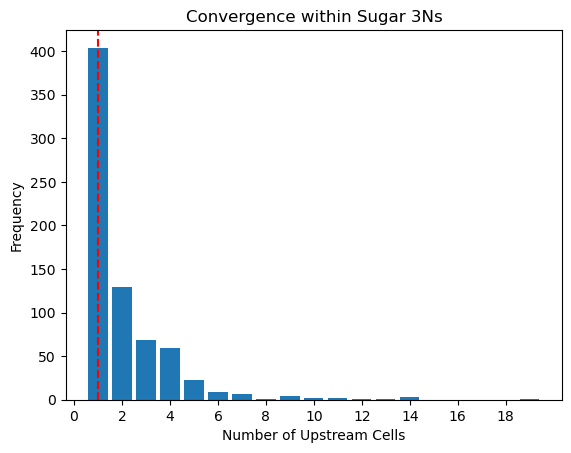

In [66]:
#Visualizing convergence within Sugar 3Ns
#Outputs a bar chart with the number of upstream cells for each 3N

data = Counter(sugar3N_upstream_cells['#_upstream_cells'])
labels = list(data.keys())
frequencies = list(data.values())
plt.bar(labels, frequencies)
plt.axvline(x=np.median(sugar3N_upstream_cells['#_upstream_cells']), color='r', linestyle='--', label='Median')
plt.xticks(np.arange(0, max(sugar3N_upstream_cells['#_upstream_cells']) + 1, step=2))
plt.xlabel('Number of Upstream Cells')
plt.ylabel('Frequency')
plt.title('Convergence within Sugar 3Ns')
plt.show()

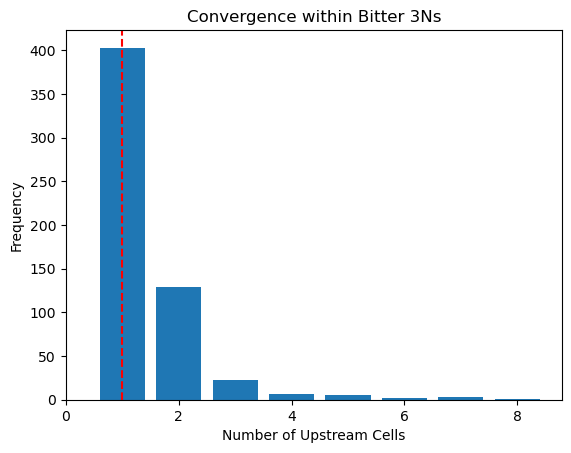

In [67]:
#Visualizing convergence within Bitter 3Ns
#Outputs a bar chart with the number of upstream cells for each 3N

data = Counter(bitter3N_upstream_cells['#_upstream_cells'])
labels = list(data.keys())
frequencies = list(data.values())
plt.bar(labels, frequencies)
plt.axvline(x=np.median(bitter3N_upstream_cells['#_upstream_cells']), color='r', linestyle='--', label='Median')
plt.xticks(np.arange(0, max(bitter3N_upstream_cells['#_upstream_cells']) + 1, step=2))
plt.xlabel('Number of Upstream Cells')
plt.ylabel('Frequency')
plt.title('Convergence within Bitter 3Ns')
plt.show()

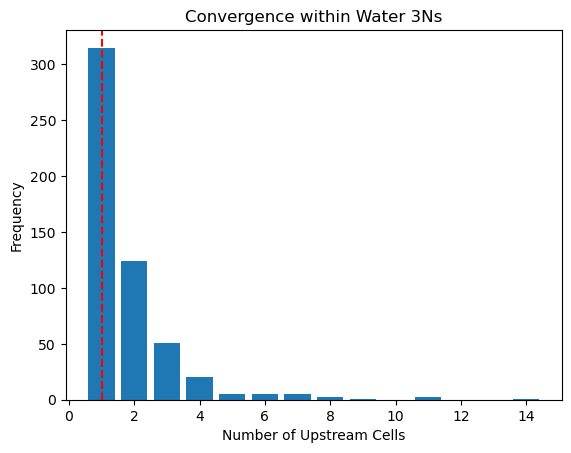

In [68]:
#Visualizing convergence within Water 3Ns
#Outputs a bar chart with the number of upstream cells for each 3N

data = Counter(water3N_upstream_cells['#_upstream_cells'])
labels = list(data.keys())
frequencies = list(data.values())
plt.bar(labels, frequencies)
plt.axvline(x=np.median(water3N_upstream_cells['#_upstream_cells']), color='r', linestyle='--', label='Median')
plt.xticks(np.arange(0, max(water3N_upstream_cells['#_upstream_cells']) + 1, step=2))
plt.xlabel('Number of Upstream Cells')
plt.ylabel('Frequency')
plt.title('Convergence within Water 3Ns')
plt.show()

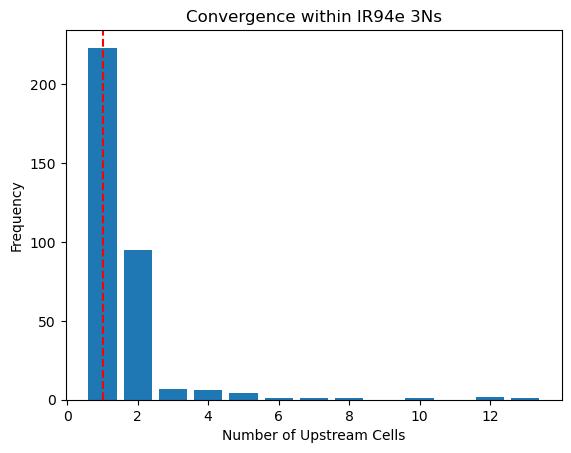

In [69]:
#Visualizing convergence within Water 3Ns
#Outputs a bar chart with the number of upstream cells for each 3N

data = Counter(lowsalt3N_upstream_cells['#_upstream_cells'])
labels = list(data.keys())
frequencies = list(data.values())
plt.bar(labels, frequencies)
plt.axvline(x=np.median(lowsalt3N_upstream_cells['#_upstream_cells']), color='r', linestyle='--', label='Median')
plt.xticks(np.arange(0, max(lowsalt3N_upstream_cells['#_upstream_cells']) + 1, step=2))
plt.xlabel('Number of Upstream Cells')
plt.ylabel('Frequency')
plt.title('Convergence within IR94e 3Ns')
plt.show()

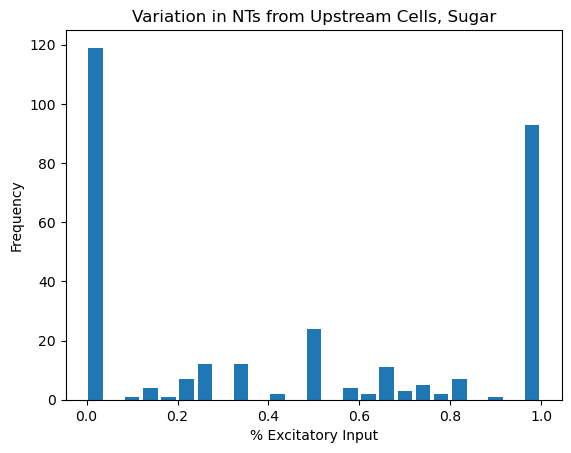

In [70]:
# This creates a bar graph of whether all of the connections to a sugar third order cell involves 
# one NT type or multiple

data = sugar3N_upstream_cells[sugar3N_upstream_cells['#_upstream_cells'] != 1]['% excitatory input']

num_bins = 25
bins = np.linspace(min(data), max(data), num_bins + 1)
frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
plt.bar(bin_labels, frequencies, width=(max(data) - min(data)) / num_bins * 0.8, align='center')
plt.xlabel('% Excitatory Input')
plt.ylabel('Frequency')
plt.title('Variation in NTs from Upstream Cells, Sugar')
plt.show()

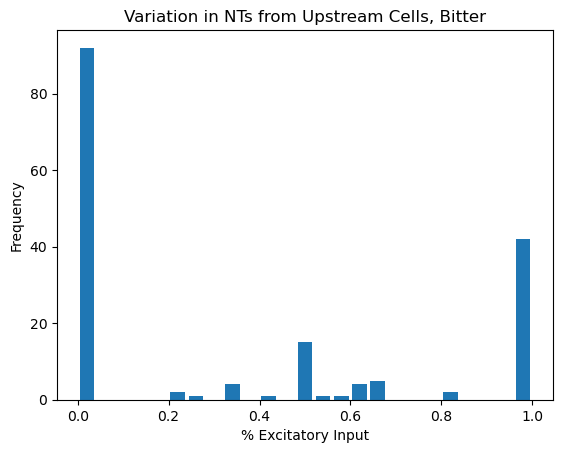

In [71]:
# This creates a bar graph of whether all of the connections to a bitter third order cell involves 
# one NT type or multiple

data = bitter3N_upstream_cells[bitter3N_upstream_cells['#_upstream_cells'] != 1]['% excitatory input']

num_bins = 25
bins = np.linspace(min(data), max(data), num_bins + 1)
frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
plt.bar(bin_labels, frequencies, width=(max(data) - min(data)) / num_bins * 0.8, align='center')
plt.xlabel('% Excitatory Input')
plt.ylabel('Frequency')
plt.title('Variation in NTs from Upstream Cells, Bitter')
plt.show()

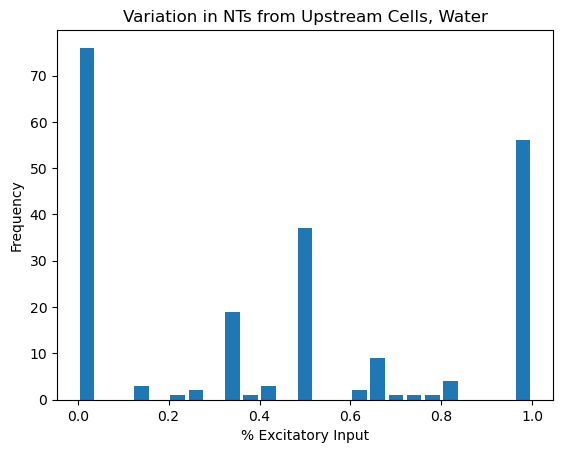

In [72]:
# This creates a bar graph of whether all of the connections to a water third order cell involves 
# one NT type or multiple

data = water3N_upstream_cells[water3N_upstream_cells['#_upstream_cells'] != 1]['% excitatory input']

num_bins = 25
bins = np.linspace(min(data), max(data), num_bins + 1)
frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
plt.bar(bin_labels, frequencies, width=(max(data) - min(data)) / num_bins * 0.8, align='center')
plt.xlabel('% Excitatory Input')
plt.ylabel('Frequency')
plt.title('Variation in NTs from Upstream Cells, Water')
plt.show()

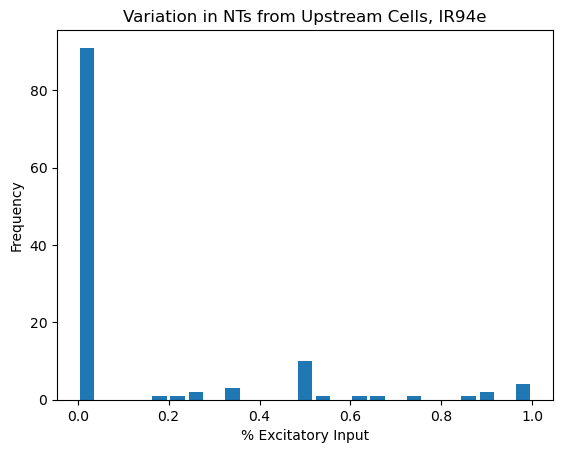

In [73]:
# This creates a bar graph of whether all of the connections to a IR94e third order cell involves 
# one NT type or multiple

data = lowsalt3N_upstream_cells[lowsalt3N_upstream_cells['#_upstream_cells'] != 1]['% excitatory input']

num_bins = 25
bins = np.linspace(min(data), max(data), num_bins + 1)
frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
plt.bar(bin_labels, frequencies, width=(max(data) - min(data)) / num_bins * 0.8, align='center')
plt.xlabel('% Excitatory Input')
plt.ylabel('Frequency')
plt.title('Variation in NTs from Upstream Cells, IR94e')
plt.show()

### Looking at the cross-over between modalities within the third-order cells
This code will provide information about how many cells are downstream from multiple distinct taste modalities 

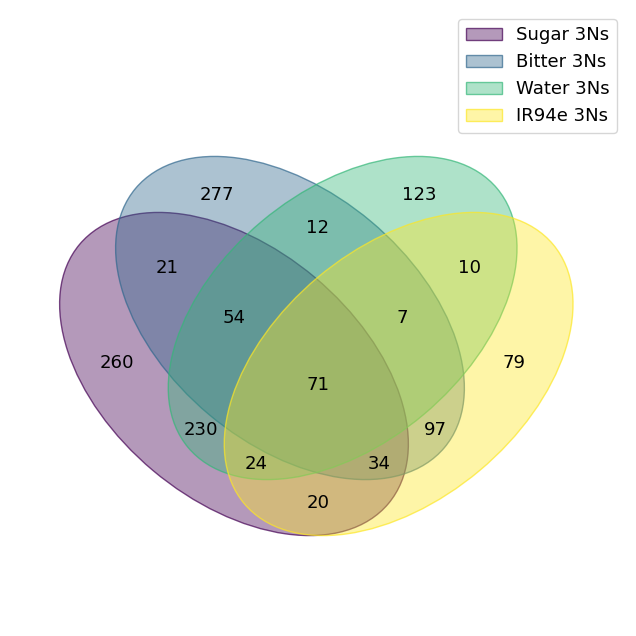

In [74]:
sugar_column = 'Sugar 3Ns'
sugar_list = {'{}'.format(value) for value in sugar_third_order['third_order_cell_ID'].unique()}
sugar_dict = {sugar_column: sugar_list}

bitter_column = 'Bitter 3Ns'
bitter_list = {'{}'.format(value) for value in bitter_third_order['third_order_cell_ID'].unique()}
bitter_dict = {bitter_column: bitter_list}

water_column = 'Water 3Ns'
water_list = {'{}'.format(value) for value in water_third_order['third_order_cell_ID'].unique()}
water_dict = {water_column: water_list}

lowsalt_column = 'IR94e 3Ns'
lowsalt_list = {'{}'.format(value) for value in lowsalt_third_order['third_order_cell_ID'].unique()}
lowsalt_dict = {lowsalt_column: lowsalt_list}

crossover = {**sugar_dict, **bitter_dict, **water_dict, **lowsalt_dict}
venn(crossover)
plt.show()

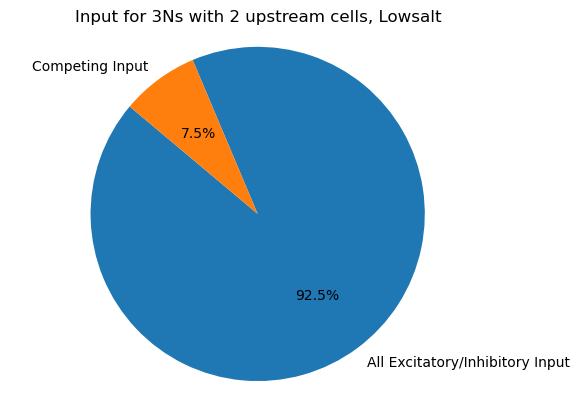

In [75]:
# Looks at whether 3N cells are receiving competing or complementary input
# Outputs a pie chart that displays the breakdown within IR94e cells
# COME BACK -- DID I CHANGE THE PARAMETERS OF FUNCTIONS?? -- LOOK AT WHAT WE EXPECT BASELINE TO BE... IE VIOLIN PLOT

labels = ['All Excitatory/Inhibitory Input', 'Competing Input']
sizes = [len(lowsalt3N_upstream_cells[(lowsalt3N_upstream_cells['#_upstream_cells'] == 2) & ((lowsalt3N_upstream_cells['% excitatory input'] == 0 ) | (lowsalt3N_upstream_cells['% excitatory input'] == 1 ))]), 
         len((lowsalt3N_upstream_cells[(lowsalt3N_upstream_cells['#_upstream_cells'] == 2) & (lowsalt3N_upstream_cells['% excitatory input'] == 0.5 )]))]
plt.pie(sizes, labels = labels, autopct='%1.1f%%', startangle=140)
plt.title('Input for 3Ns with 2 upstream cells, Lowsalt')
plt.axis('equal')
plt.show()


## Fourth Order Neurons

In [76]:
sugar_third_order[0:3]

,second_order_cell_ID,second_order_cell_label,third_order_cell_ID,neuropil,syn_count,nt_type,location_of_connection
2,720575940642361485,[],720575940616103218,GNG,11,ACH,local
5,720575940642361485,[],720575940639274147,GNG,13,ACH,local
7,720575940642361485,[],720575940620874757,GNG,13,ACH,local


In [77]:
def fourth_order(taste_third_order, connections_dataset, taste_GRNs):
    for entry in taste_third_order['third_order_cell_ID']:
        if entry in taste_GRNs['root_id']:
            pass
        if entry in taste_third_order['second_order_cell_ID']:
            pass
        else:
            merge = pd.merge(taste_third_order['third_order_cell_ID'], connections, left_on='third_order_cell_ID', right_on='pre_root_id', how = 'inner').query("syn_count >=10")
        merge = merge.drop(columns = 'pre_root_id')
        merge = merge.rename(columns={'post_root_id':'fourth_order_cell_ID'})
        def projection(neuropil):
            if neuropil in ['GNG', 'PRW', 'SAD', 'FLA_L', 'FLA_R']:
                return 'local'
            else: 
                return 'outside_SEZ'
        merge['location_of_connection'] = merge['neuropil'].apply(projection)
        return merge

In [78]:
sugar_fourth_order = fourth_order(sugar_third_order, connections, sugar_GRNs)
bitter_fourth_order = fourth_order(bitter_third_order, connections, bitter_GRNs)
water_fourth_order = fourth_order(water_third_order, connections, water_GRNs)
lowsalt_fourth_order = fourth_order(lowsalt_third_order, connections, lowsalt_GRNs)

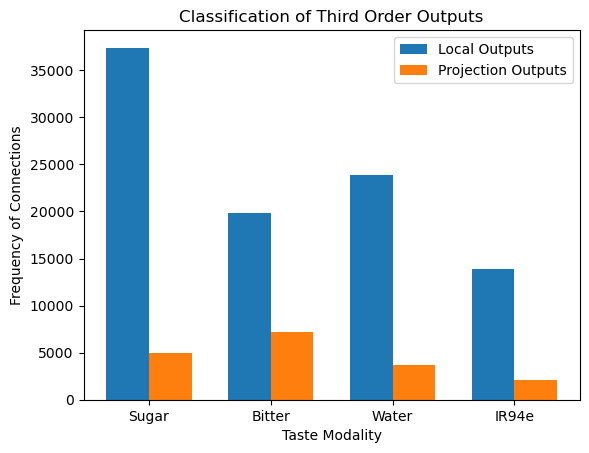

In [79]:
# Identifying the % of local/non-local second to third order CONNECTIONS for all tastes
# NEW

categories = ['Sugar','Bitter','Water','IR94e']
variable1 = [len(sugar_fourth_order.query("location_of_connection == 'local'")),
             len(bitter_fourth_order.query("location_of_connection == 'local'")),
             len(water_fourth_order.query("location_of_connection == 'local'")),
             len(lowsalt_fourth_order.query("location_of_connection == 'local'"))]
variable2 = [len(sugar_fourth_order.query("location_of_connection == 'outside_SEZ'")),
             len(bitter_fourth_order.query("location_of_connection == 'outside_SEZ'")),
             len(water_fourth_order.query("location_of_connection == 'outside_SEZ'")),
             len(lowsalt_fourth_order.query("location_of_connection == 'outside_SEZ'"))]

x = range(len(categories))

bar_width = 0.35

plt.bar(x, variable1, width=bar_width,label = "Local Outputs")
plt.bar([i+ bar_width for i in x], variable2, width=bar_width, label = "Projection Outputs")

plt.xlabel('Taste Modality')
plt.ylabel('Frequency of Connections')
plt.title('Classification of Third Order Outputs')
plt.xticks([i + bar_width / 2 for i in x], categories)
plt.legend()
plt.show()

In [80]:
# len(sugar_fourth_order[sugar_fourth_order['third_order_cell_ID'] == 720575940631967506])

(sugar_fourth_order[sugar_fourth_order['third_order_cell_ID'] == 720575940631967506]['location_of_connection'] == 'local').sum()/len(sugar_fourth_order[sugar_fourth_order['third_order_cell_ID'] == 720575940631967506]) >= 0.1
#sugar_fourth_order

True

In [81]:
# This function classifies neurons as local or non-local based on whether they have atleast 10% of
# connections outside of the SEZ
# THRESHOLD = ATLEAST 10 CONNECTIONS FROM GRN

def classify3N(taste_fourth_order):
    classification = pd.DataFrame(columns = ['third_order_cell_ID', 'projection','#_of_external_projections'])
    unique_values = taste_fourth_order['third_order_cell_ID'].unique()
    for entry in unique_values:
        
        if all(taste_fourth_order[taste_fourth_order['third_order_cell_ID'] == entry]['location_of_connection'] == 'local'):
        #if (taste_fourth_order[taste_fourth_order['third_order_cell_ID'] == entry]['location_of_connection'] == 'local').sum()/len(taste_fourth_order[taste_fourth_order['third_order_cell_ID'] == entry]) >= 0.1:
            x = pd.DataFrame({'third_order_cell_ID': [entry], 'projection':'local','#_of_external_projections':(taste_fourth_order[taste_fourth_order['third_order_cell_ID'] == entry]['location_of_connection'] == 'outside_SEZ').sum()})
            classification = pd.concat([classification,x])
        else:
            x = pd.DataFrame({'third_order_cell_ID': [entry], 'projection':'outside_SEZ','#_of_external_projections':(taste_fourth_order[taste_fourth_order['third_order_cell_ID'] == entry]['location_of_connection'] == 'outside_SEZ').sum()})
            classification = pd.concat([classification,x])
    return classification

In [82]:
# Outputs third order cells and their classification of local/outside SEZ and their number
# of external projections

sugar_third_order_projection = classify3N(sugar_fourth_order)
bitter_third_order_projection = classify3N(bitter_fourth_order)
water_third_order_projection = classify3N(water_fourth_order)
lowsalt_third_order_projection = classify3N(lowsalt_fourth_order)

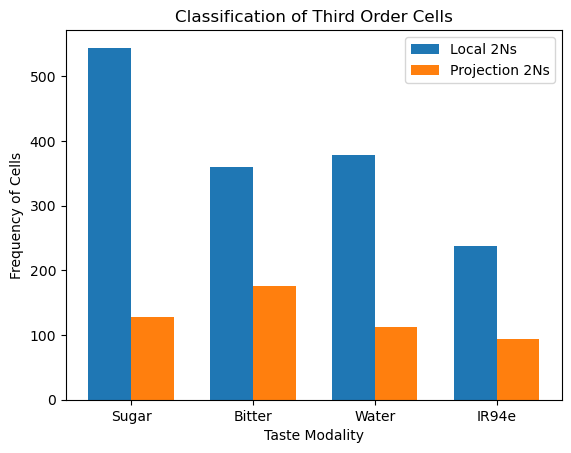

In [83]:
# Identifying the % of local/non-local third to fourth order CELLS for all tastes
# NEW

categories = ['Sugar','Bitter','Water','IR94e']
variable1 = [len(sugar_third_order_projection.query("projection == 'local'")),
             len(bitter_third_order_projection.query("projection == 'local'")),
             len(water_third_order_projection.query("projection == 'local'")),
             len(lowsalt_third_order_projection.query("projection == 'local'"))]
variable2 = [len(sugar_third_order_projection.query("projection == 'outside_SEZ'")),
             len(bitter_third_order_projection.query("projection == 'outside_SEZ'")),
             len(water_third_order_projection.query("projection == 'outside_SEZ'")),
             len(lowsalt_third_order_projection.query("projection == 'outside_SEZ'"))]

x = range(len(categories))

bar_width = 0.35

plt.bar(x, variable1, width=bar_width,label = "Local 2Ns")
plt.bar([i+ bar_width for i in x], variable2, width=bar_width, label = "Projection 2Ns")

plt.xlabel('Taste Modality')
plt.ylabel('Frequency of Cells')
plt.title('Classification of Third Order Cells')
plt.xticks([i + bar_width / 2 for i in x], categories)
plt.legend()
plt.show()

In [84]:
sugar_fourth_order.groupby('neuropil')['syn_count'].sum().reset_index().sort_values(by='syn_count', ascending=False)

,neuropil,syn_count
15,GNG,1072211
34,PRW,106186
43,SMP_L,14802
25,LAL_R,13864
44,SMP_R,10105
13,FLA_L,9234
26,LH_L,8035
6,AVLP_L,6570
41,SLP_L,6262
24,LAL_L,5819


In [85]:
bitter_fourth_order.groupby('neuropil')['syn_count'].sum().reset_index().sort_values(by='syn_count', ascending=False)

,neuropil,syn_count
13,GNG,494723
33,PRW,101415
43,SMP_L,20402
41,SLP_L,18741
3,AVLP_L,11823
37,SCL_L,11807
22,LH_L,11434
4,AVLP_R,11123
42,SLP_R,10536
23,LH_R,7596


In [86]:
water_fourth_order.groupby('neuropil')['syn_count'].sum().reset_index().sort_values(by='syn_count', ascending=False)

,neuropil,syn_count
12,GNG,751638
33,PRW,49391
22,LH_L,9158
39,SLP_L,8486
37,SCL_L,6462
17,ICL_L,4921
40,SLP_R,4041
18,ICL_R,3786
3,AVLP_L,3729
11,FLA_R,3604


In [87]:
lowsalt_fourth_order.groupby('neuropil')['syn_count'].sum().reset_index().sort_values(by='syn_count', ascending=False)

,neuropil,syn_count
8,GNG,310256
24,PRW,59665
32,SLP_L,11386
33,SLP_R,7211
34,SMP_L,5262
6,FLA_L,3774
7,FLA_R,3067
15,LH_L,2799
35,SMP_R,2038
27,SAD,1911


In [88]:
lowsalt_fourth_order[lowsalt_fourth_order['neuropil'] == 'GNG']['syn_count'].sum()

310256

In [89]:
unique_values = sugar_fourth_order['neuropil'].unique()
for neuropil in unique_values:
    if neuropil in ['GNG', 'PRW', 'SAD', 'FLA_L', 'FLA_R']:
        print(neuropil)

GNG
PRW
FLA_L
SAD
FLA_R


In [90]:
def brain_regions(taste_fourth_order):
    regions = pd.DataFrame(columns=['neuropil', '#_synapses'])  # Correct
    unique_values = taste_fourth_order['neuropil'].unique()
    for neuropil in unique_values:
        if neuropil in ['GNG', 'PRW', 'SAD', 'FLA_L', 'FLA_R']:
            continue
        else:
            x = pd.DataFrame({'neuropil': [neuropil], '#_synapses': [taste_fourth_order[taste_fourth_order['neuropil'] == neuropil]['syn_count'].sum()]})
            regions = pd.concat([regions, x], ignore_index=True)  # Correctly specify the list of DataFrames to concatenate
    return regions.sort_values(by='#_synapses', ascending=False)


In [91]:
sugar4N_brain_regions = brain_regions(sugar_fourth_order)
bitter4N_brain_regions = brain_regions(bitter_fourth_order)
water4N_brain_regions = brain_regions(water_fourth_order)
lowsalt4N_brain_regions = brain_regions(lowsalt_fourth_order)

In [92]:
region_mapping = {
    'SLP_L': 'SLP','SLP_R': 'SLP',
    'SCP_L': 'SCP','SCP_R': 'SCP',
    'SMP_L': 'SMP','SMP_R': 'SMP',
    'LAL_L' : 'LAL','LAL_R' : 'LAL',
    'AVLP_L' : 'AVLP','AVLP_R' : 'AVLP',
    'VES_L' : 'VES','VES_R' : 'VES',
    'LH_L' : 'LH','LH_R' : 'LH',
    'PLP_L' : 'PLP','PLP_R' : 'PLP',
    'PVLP_L' : 'PVLP','PVLP_R' : 'PVLP',
    'SCL_L' : 'SCL','SCL_R' : 'SCL',
    'ICL_L' : 'ICL','ICL_R' : 'ICL',
    'IPS_L' : 'IPS','IPS_R' : 'IPS',
    'SPS_L' : 'SPS', 'SPS_R' : 'SPS',
    'AOTU_L' : 'AOTU', 'AOTU_R' : 'AOTU',
    'SIP_L' : 'SIP', 'SIP_R' : 'SIP',
    'MB_CA_L' :'MB_CA', 'MB_CA_R' : 'MB_CA',
    'AL_L' :'AL', 'AL_R' : 'AL',
    'CRE_L' : 'CRE', 'CRE_R' : 'CRE'
}

In [93]:
sugar4N_brain_regions['neuropil'] = sugar4N_brain_regions['neuropil'].map(lambda x: region_mapping.get(x, x))
aggregated_sugar = sugar4N_brain_regions.groupby('neuropil')['#_synapses'].sum().reset_index()
aggregated_sugar = aggregated_sugar.sort_values(by='#_synapses', ascending=False)

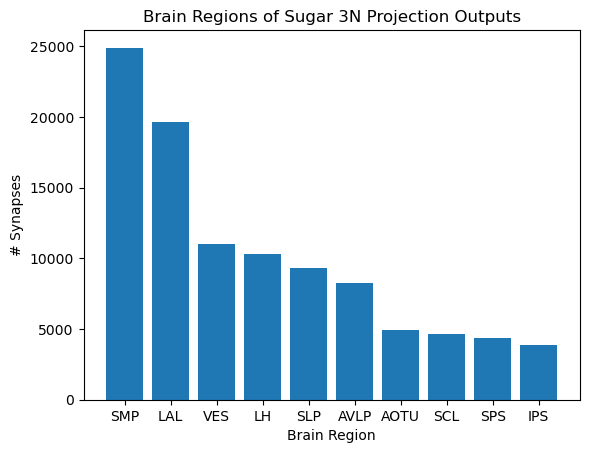

In [94]:
# Brain regions of 3N to 4N sugar connecitons

bar_width = 0.35

plt.bar(aggregated_sugar.iloc[0:10]['neuropil'], aggregated_sugar.iloc[0:10]['#_synapses'])
plt.xlabel("Brain Region")
plt.ylabel("# Synapses")
plt.title("Brain Regions of Sugar 3N Projection Outputs")
plt.show()

In [95]:
bitter4N_brain_regions['neuropil'] = bitter4N_brain_regions['neuropil'].map(lambda x: region_mapping.get(x, x))
aggregated_bitter = bitter4N_brain_regions.groupby('neuropil')['#_synapses'].sum().reset_index()
aggregated_bitter = aggregated_bitter.sort_values(by='#_synapses', ascending=False)

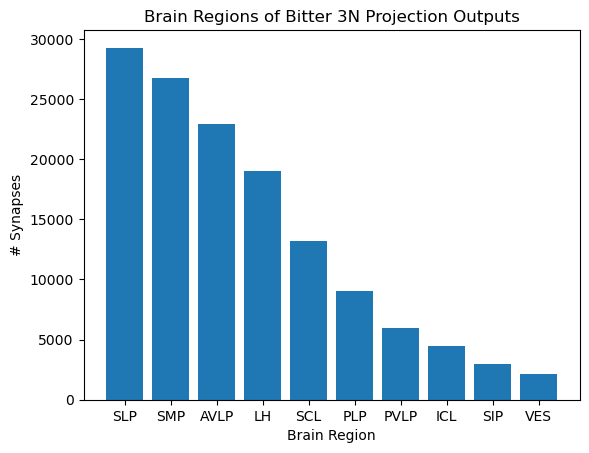

In [96]:
# Brain regions of 3N to 4N bitter connecitons

bar_width = 0.35

plt.bar(aggregated_bitter.iloc[0:10]['neuropil'], aggregated_bitter.iloc[0:10]['#_synapses'])
plt.xlabel("Brain Region")
plt.ylabel("# Synapses")
plt.title("Brain Regions of Bitter 3N Projection Outputs")
plt.show()

In [97]:
water4N_brain_regions['neuropil'] = water4N_brain_regions['neuropil'].map(lambda x: region_mapping.get(x, x))
aggregated_water = water4N_brain_regions.groupby('neuropil')['#_synapses'].sum().reset_index()
aggregated_water = aggregated_water.sort_values(by='#_synapses', ascending=False)

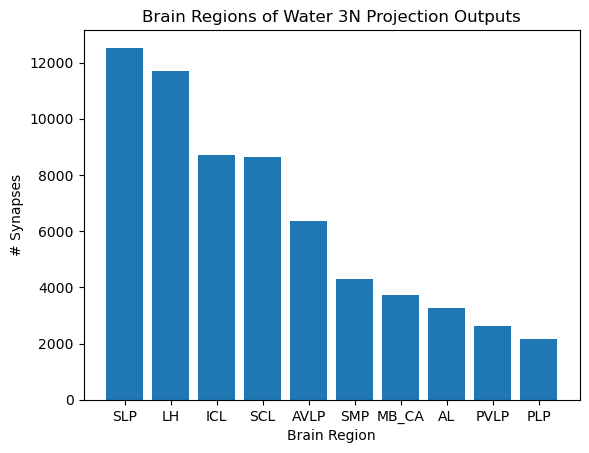

In [98]:
# Brain regions of 3N to 4N water connecitons

bar_width = 0.35

plt.bar(aggregated_water.iloc[0:10]['neuropil'], aggregated_water.iloc[0:10]['#_synapses'])
plt.xlabel("Brain Region")
plt.ylabel("# Synapses")
plt.title("Brain Regions of Water 3N Projection Outputs")
plt.show()

In [99]:
lowsalt4N_brain_regions['neuropil'] = lowsalt4N_brain_regions['neuropil'].map(lambda x: region_mapping.get(x, x))
aggregated_lowsalt = lowsalt4N_brain_regions.groupby('neuropil')['#_synapses'].sum().reset_index()
aggregated_lowsalt = aggregated_lowsalt.sort_values(by='#_synapses', ascending=False)

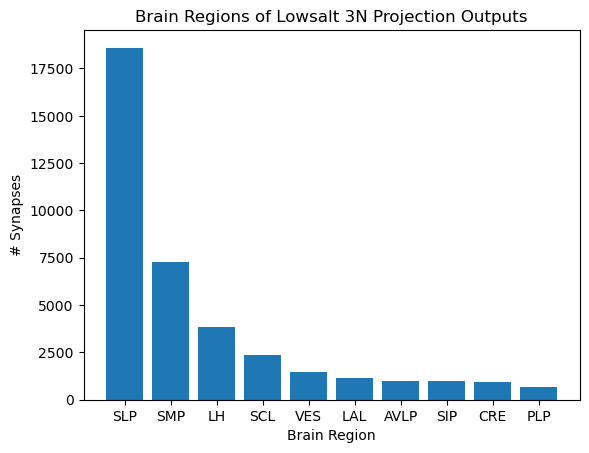

In [100]:
# Brain regions of 3N to 4N IR94e connecitons

bar_width = 0.35

plt.bar(aggregated_lowsalt.iloc[0:10]['neuropil'], aggregated_lowsalt.iloc[0:10]['#_synapses'])
plt.xlabel("Brain Region")
plt.ylabel("# Synapses")
plt.title("Brain Regions of Lowsalt 3N Projection Outputs")
plt.show()

In [101]:
display(aggregated_sugar[0:3])
display(aggregated_bitter[0:3])

,neuropil,#_synapses
25,SMP,24907
15,LAL,19683
27,VES,11004


,neuropil,#_synapses
26,SLP,29277
27,SMP,26743
2,AVLP,22946


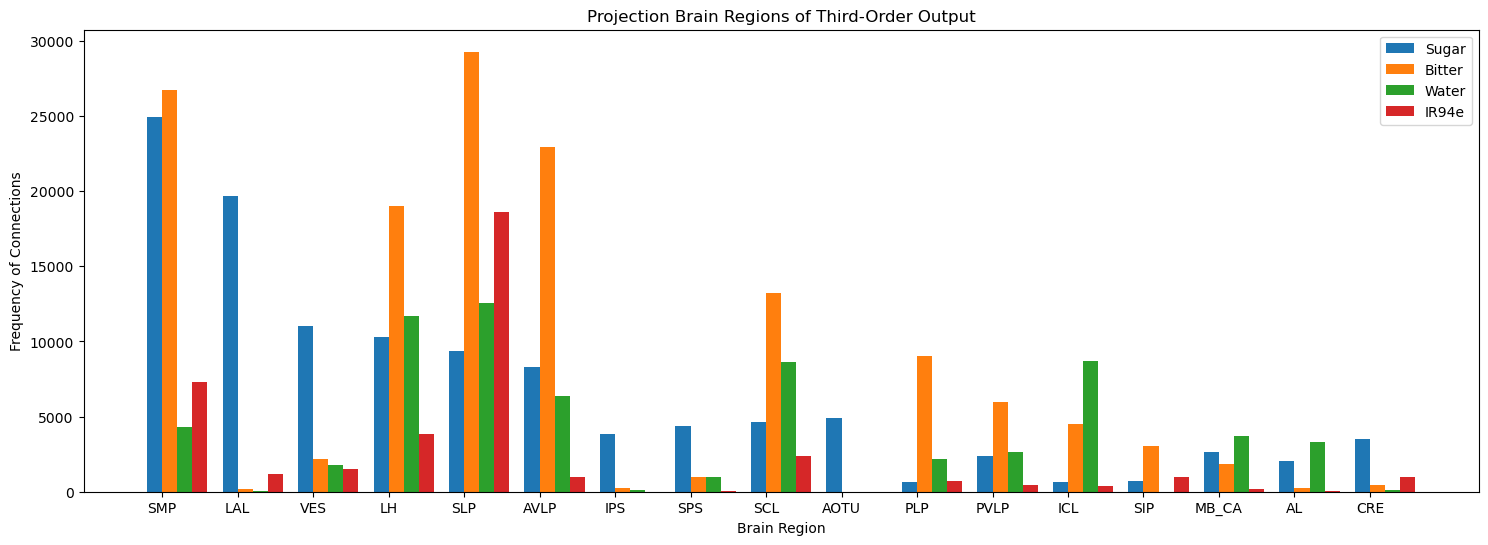

In [102]:
categories = ['SMP', 'LAL', 'VES', 'LH','SLP','AVLP','IPS','SPS','SCL','AOTU','PLP','PVLP','ICL','SIP','MB_CA','AL','CRE']

def count_categories(aggregated_taste, categories_array):
    variable = []
    for category in categories:
        if len(aggregated_taste[aggregated_taste['neuropil'] == category]) == 0:
            variable.append(0)
        else:   
            variable.append(aggregated_taste[aggregated_taste['neuropil'] == category ].iloc[0,1])
    return variable

variable1 = count_categories(aggregated_sugar, categories)
variable2 = count_categories(aggregated_bitter, categories)
variable3 = count_categories(aggregated_water, categories)
variable4 = count_categories(aggregated_lowsalt, categories)

x = range(len(categories))

bar_width = 0.2

plt.figure(figsize=(18, 6))
plt.bar(x, variable1, width=bar_width, label='Sugar')
plt.bar([i + bar_width for i in x], variable2, width=bar_width, label = 'Bitter')
plt.bar([i + 2*bar_width for i in x], variable3, width=bar_width, label = 'Water')
plt.bar([i + 3*bar_width for i in x], variable4, width=bar_width, label = 'IR94e')


plt.xlabel('Brain Region')
plt.ylabel('Frequency of Connections')
plt.title('Projection Brain Regions of Third-Order Output')
plt.xticks([i + bar_width / 2 for i in x], categories)
plt.legend()
plt.show()

In [103]:
# Function that tells us the distribution of NTs involved in 2N to 3N connections

def nt_connections(taste_fourth_order):
    connections = pd.DataFrame(columns = ['nt_type', '%_input'])
    unique_values = taste_fourth_order['nt_type'].unique()
    x = [pd.DataFrame({'nt_type': [entry], '%_input': len(taste_fourth_order[taste_fourth_order['nt_type'] == entry ])/len(taste_fourth_order)*100}) for entry in unique_values]
    connections = pd.concat(x, ignore_index = True)
    return connections

sugar_4N_NTs = nt_connections(sugar_fourth_order)
bitter_4N_NTs = nt_connections(bitter_fourth_order)
water_4N_NTs = nt_connections(water_fourth_order)
lowsalt_4N_NTs = nt_connections(lowsalt_fourth_order)

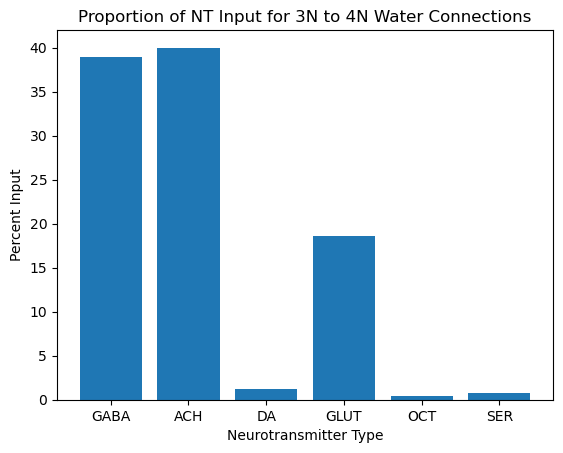

In [104]:
# NTs involved in 2N to 3N IR94e connections

plt.bar(water_4N_NTs['nt_type'], water_4N_NTs['%_input'])
plt.xlabel("Neurotransmitter Type")
plt.ylabel("Percent Input")
plt.title("Proportion of NT Input for 3N to 4N Water Connections")
plt.show()